In [ ]:
# Process to generate training splits from sampled datasets
import os
import pandas as pd
from recbole.config import Config
from recbole.data import create_dataset
from recbole.utils import init_seed

# Directory where the sampled datasets are located
sampled_dataset_dir = './dataset_sampled/'
# Directory where the training splits will be saved
output_dir = './dataset_sampled_train_split/'
os.makedirs(output_dir, exist_ok=True)

# Obtain list of sampled datasets (folder names are the same as dataset names)
sampled_datasets = [d for d in os.listdir(sampled_dataset_dir) if os.path.isdir(os.path.join(sampled_dataset_dir, d))]
print(f"Found {len(sampled_datasets)} sampled datasets.")

for dataset_name in sampled_datasets:
    print(f"\nProcessing dataset: {dataset_name}...")
    try:
        # A generic model is used that will not affect, the seed is fixed to the default value
        config = Config(
            model='BPR',
            dataset=dataset_name,
            config_dict={
                'data_path': sampled_dataset_dir,
                'seed': 2020,
                'eval_args': {
                    'split': {'RS': [0.8, 0.1, 0.1]},
                    'order': 'RO',
                    'group_by': 'user',
                    'mode': 'uni100'
                },
                'USER_ID_FIELD': 'user_id',
                'ITEM_ID_FIELD': 'item_id',
                'RATING_FIELD': 'rating',
                'TIME_FIELD': 'timestamp',
            }
        )
        init_seed(config['seed'], config['reproducibility'])
        dataset = create_dataset(config)
        # The build() method applies 'eval_args' configuration to split data.
        built_datasets = dataset.build()
        train_dataset = built_datasets[0]
        # extracts data from the .inter file
        interaction = train_dataset.inter_feat
        interaction_dict = interaction.numpy()
        train_df = pd.DataFrame(interaction_dict)
        # Map internal IDs back to original tokens
        for field in train_df.columns:
            if field in dataset.field2id_token:
                train_df[field] = dataset.id2token(field, train_df[field].values)
        
        train_df_renamed = train_df.rename(columns={
            config['USER_ID_FIELD']: config['USER_ID_FIELD'] + ':token',
            config['ITEM_ID_FIELD']: config['ITEM_ID_FIELD'] + ':token',
            config['RATING_FIELD']: config['RATING_FIELD'] + ':float',
            config['TIME_FIELD']: config['TIME_FIELD'] + ':float',
        })

        output_path = os.path.join(output_dir, f"{dataset_name}.inter")
        train_df_renamed.to_csv(output_path, sep='\t', index=False)
        print(f"Training split saved at: {output_path}")


        

    except Exception as e:
        print(f'Error with {dataset_name}: {e}')
        

In [ ]:
import os
import pandas as pd

original_sampled_dir = './dataset_sampled/'
train_split_dir = './dataset_sampled_train_split/'
output_dir_full = './dataset_sampled_train_split_full/'
os.makedirs(output_dir_full, exist_ok=True)

# Get list of training split files
train_split_files = [f for f in os.listdir(train_split_dir) if f.endswith('.inter')]
print(f"Found {len(train_split_files)} training splits to process.")

for split_filename in train_split_files:
    dataset_name = split_filename.replace('.inter', '')

    try:
        original_inter_path = os.path.join(original_sampled_dir, dataset_name, f"{dataset_name}.inter")
        df_original = pd.read_csv(original_inter_path, sep='\t')
        df_original.rename(columns={'user_id:token': 'user_id', 'item_id:token': 'item_id'}, inplace=True)
        split_inter_path = os.path.join(train_split_dir, split_filename)
        df_split = pd.read_csv(split_inter_path, sep='\t')
        df_split.rename(columns={'user_id:token': 'user_id', 'item_id:token': 'item_id'}, inplace=True)
        df_final = pd.merge(df_original, df_split[['user_id', 'item_id']], on=['user_id', 'item_id'], how='inner')
        df_final.rename(columns={'user_id': 'user_id:token', 'item_id': 'item_id:token'}, inplace=True)
        output_path = os.path.join(output_dir_full, split_filename)
        df_final.to_csv(output_path, sep='\t', index=False)
        print(f"Full training split saved at: {output_path}")


    except Exception as e:
        print(f'Error processing {dataset_name}: {e}')

In [ ]:
# Post-processing for DianPing which has NaNs in rating
import os
import pandas as pd
import glob

# Directory where the datasets are located (adjust if your path is different)
dataset_base_dir = './dataset_sampled_train_split_full/'

# Search for files matching DianPing_sample*.inter directly
dianping_files = glob.glob(os.path.join(dataset_base_dir, 'DianPing_sample*.inter'))

print(f"Found {len(dianping_files)} DianPing files to process.")

for file_path in dianping_files:
    # Get the dataset name from the filename
    filename = os.path.basename(file_path)
    dataset_name = filename.replace('.inter', '')
    
    try:
        # Load the .inter file
        df = pd.read_csv(file_path, sep='\t')
        
        # Identify the rating column (usually 'rating:float')
        rating_col = [col for col in df.columns if 'rating' in col]
        
        if rating_col:
            col_name = rating_col[0]
            # Check for NaNs
            if df[col_name].isnull().any():
                nan_count = df[col_name].isnull().sum()
                print(f"--> Correcting {dataset_name}: Found {nan_count} NaN values in '{col_name}'.")
                
                # Replace NaN with 0.0
                df[col_name] = df[col_name].fillna(0.0)
                
                # Save the corrected file
                df.to_csv(file_path, sep='\t', index=False)
                print(f"    File saved successfully: {file_path}")
            else:
                print(f"--> {dataset_name}: No NaN values found in '{col_name}'.")
        else:
            print(f"--> Warning in {dataset_name}: No rating column found.")
            
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")

print("\nCleaning process completed.")

In [ ]:
# Processing for Steam to work on the 3 samples
import os
import pandas as pd

# Base directory
base_dir = 'dataset_sampled_train_split_full/'
dataset_prefix = 'steam'

# Iterate over the 3 samples
for i in range(1, 4):
    filename = f"{dataset_prefix}_sample{i}.inter"
    file_path = os.path.join(base_dir, filename)
    
    if os.path.exists(file_path):
        print(f"Processing {filename}...")
        try:
            # Load data
            df = pd.read_csv(file_path, sep='\t')
            
            
            # Create binary rating (1.0) since Steam usually has implicit feedback
            # and the perturbation script expects a 'rating' column
            df['rating'] = 1.0
            
            
            # Save the processed file (overwriting the original or creating a new one if you prefer)
            # Tab is used as separator to maintain consistency with .inter
            df.to_csv(file_path, sep='\t', index=False)
            print(f"  -> File saved successfully: {file_path}")
            
        except Exception as e:
            print(f"  -> Error processing {filename}: {e}")
    else:
        print(f"Warning: File not found {file_path}")

print("\nSteam processing completed.")

In [ ]:
# Post-processing for ModCloth which has NaNs in rating 
import os
import pandas as pd
import glob

# Directory where the datasets are located (adjust if your path is different)
dataset_base_dir = './dataset_sampled_train_split_full/'

# Search for files matching ModCloth*.inter directly
ModCloth_files = glob.glob(os.path.join(dataset_base_dir, 'ModCloth*.inter'))

print(f"Found {len(ModCloth_files)} ModCloth files to process.")

for file_path in ModCloth_files:
    # Get the dataset name from the filename
    filename = os.path.basename(file_path)
    dataset_name = filename.replace('.inter', '')
    
    try:
        # Load .inter file
        df = pd.read_csv(file_path, sep='\t')
        
        # Identify the rating column (usually 'rating:float')
        rating_col = [col for col in df.columns if 'rating' in col]
        
        if rating_col:
            col_name = rating_col[0]
            # Check for NaNs
            if df[col_name].isnull().any():
                nan_count = df[col_name].isnull().sum()
                print(f"--> Correcting {dataset_name}: Found {nan_count} NaN values in '{col_name}'.")
                
                # Replace NaN with 0.0
                df[col_name] = df[col_name].fillna(0.0)
                
                # Save the corrected file
                df.to_csv(file_path, sep='\t', index=False)
                print(f"    File saved successfully: {file_path}")
            else:
                print(f"--> {dataset_name}: No NaN values found in '{col_name}'.")
        else:
            print(f"--> Warning in {dataset_name}: No rating column found.")
            
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")

print("\nCleaning process completed.")

In [ ]:
# Processing for Twitch to work on the 3 samples
import os
import pandas as pd

# Base directory
base_dir = 'dataset_sampled_train_split_full/'
dataset_prefix = 'twitch-100k'

# Iterate over the 3 samples
for i in range(1, 4):
    filename = f"{dataset_prefix}_sample{i}.inter"
    file_path = os.path.join(base_dir, filename)
    
    if os.path.exists(file_path):
        print(f"Processing {filename}...")
        try:
            # Load data
            df = pd.read_csv(file_path, sep='\t')
            
            
            # Create binary rating (1.0) since Twitch usually has implicit feedback
            # and the perturbation script expects a 'rating' column
            df['rating'] = 1.0
            
            
            # Save the processed file (overwriting the original or creating a new one if you prefer)
            # Tab is used as separator to maintain consistency with .inter
            df.to_csv(file_path, sep='\t', index=False)
            print(f"  -> File saved successfully: {file_path}")
            
        except Exception as e:
            print(f"  -> Error processing {filename}: {e}")
    else:
        print(f"Warning: File not found {file_path}")

print("\nTwitch processing completed.")

In [ ]:
# Post-Processing for LastFM to work on the 3 samples
import os
import pandas as pd

# Base directory
base_dir = 'dataset_sampled_train_split_full/'
dataset_prefix = 'lastfm'

# Iterate over the 3 samples
for i in range(1, 4):
    filename = f"{dataset_prefix}_sample{i}.inter"
    file_path = os.path.join(base_dir, filename)
    
    if os.path.exists(file_path):
        print(f"Processing {filename}...")
        try:
            # Load data
            df = pd.read_csv(file_path, sep='\t')
            
            
            # Create binary rating (1.0) since LastFM usually has implicit feedback
            # and the perturbation script expects a 'rating' column
            df['rating'] = 1.0
            
            
            # Save the processed file (overwriting the original or creating a new one if you prefer)
            # Tab is used as separator to maintain consistency with .inter
            df.to_csv(file_path, sep='\t', index=False)
            print(f"  -> File saved successfully: {file_path}")
            
        except Exception as e:
            print(f"  -> Error processing {filename}: {e}")
    else:
        print(f"Warning: File not found {file_path}")

print("\nLastFM processing completed.")

In [ ]:
import os
import pandas as pd
import glob

# Dataset directory
dataset_base_dir = './dataset_sampled_train_split_full/'

# Search for files matching RateBeer_sample*.inter
ratebeer_files = glob.glob(os.path.join(dataset_base_dir, 'RateBeer_sample*.inter'))

print(f"Found {len(ratebeer_files)} RateBeer files to process.")

def convert_fraction(x):
    if isinstance(x, str) and '/' in x:
        try:
            num, den = x.split('/')
            return float(num) / float(den)
        except ValueError:
            # If split fails, try converting directly
            return float(x)
    return float(x)

for file_path in ratebeer_files:
    filename = os.path.basename(file_path)
    dataset_name = filename.replace('.inter', '')
    
    try:
        # Load the .inter file
        df = pd.read_csv(file_path, sep='\t')
        # Rename column overall to rating
        if 'overall:float' in df.columns:
            df.rename(columns={'overall:float': 'rating:float'}, inplace=True)
        
        # Identify the rating column
        rating_col = [col for col in df.columns if 'rating:float' in col]
        
        if rating_col:
            col_name = rating_col[0]
            # Check if it is of type object (string) to see if conversion is needed
            if df[col_name].dtype == 'object':
                print(f"--> Correcting {dataset_name}: Converting fractions in '{col_name}'.")
                
                # Apply conversion
                df[col_name] = df[col_name].apply(convert_fraction)
                
                # Save the corrected file
                df.to_csv(file_path, sep='\t', index=False)
                print(f"    File saved successfully: {file_path}")
            else:
                print(f"--> {dataset_name}: The column '{col_name}' is already numeric.")
        else:
            print(f"--> Warning in {dataset_name}: No rating column found.")
            
    except Exception as e:
        print(f"Error processing {dataset_name}: {e}")

print("\nRateBeer cleaning process completed.")

Cargadas 36 filas de resultados de perturbación.
Procesados 36 archivos de benchmark con éxito.
Se unieron 36 datasets con sus métricas de rendimiento y perturbación.


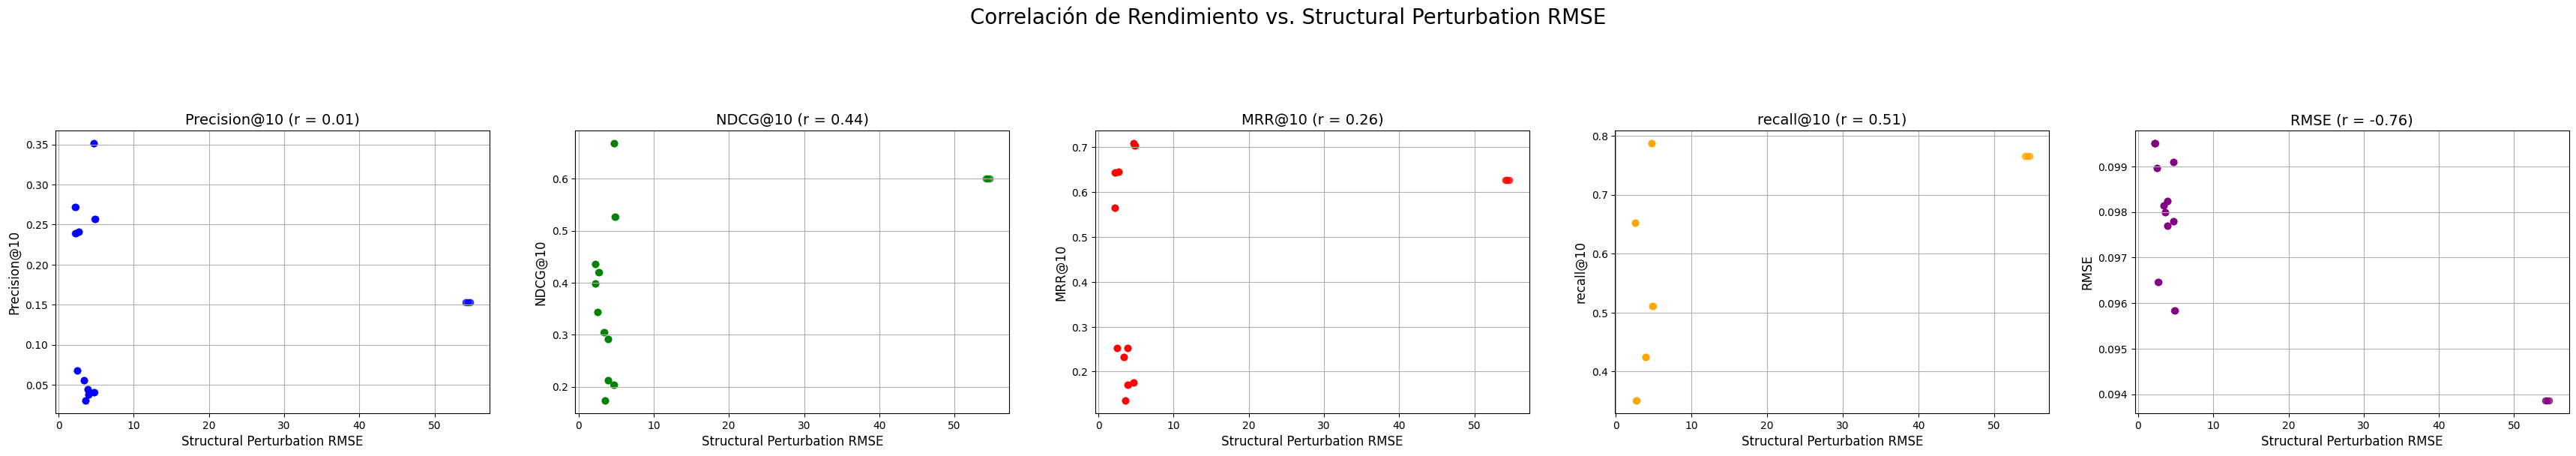

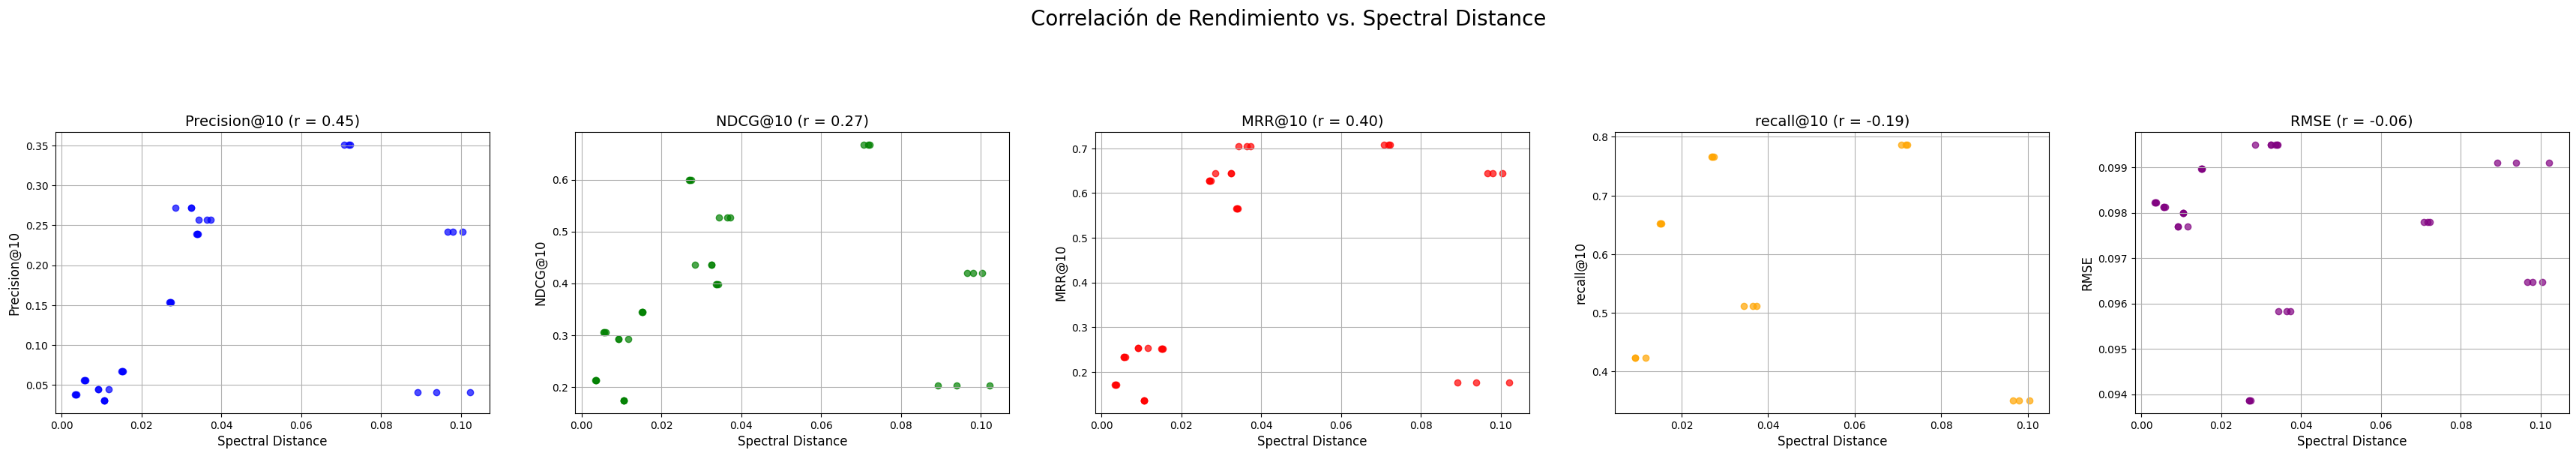

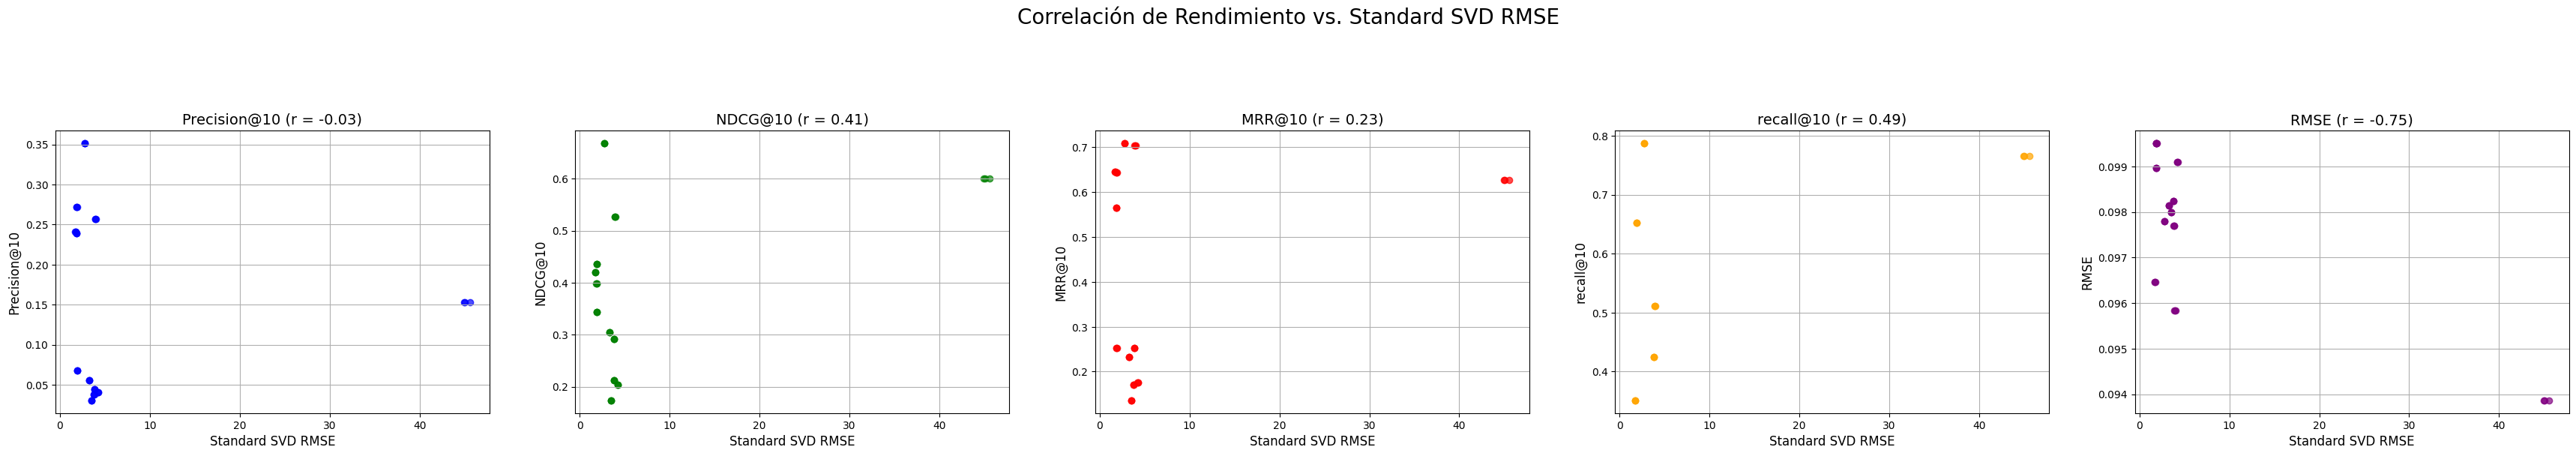

Advertencia: La métrica estructural 'Normalized RMSE' no se encontró en los datos. Saltando gráfico.


In [ ]:
## Without postprocessing of NaNs or ratings and without Normalization
## Plot of correlations between structural metrics and performance, run after having the perturbation and benchmark results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import pearsonr

# Load perturbation metrics for each dataset
try:
    perturbation_df = pd.read_csv('./structural_perturbation/perturbation_results.csv')
    # Clean dataset name to match
    perturbation_df['dataset_name'] = perturbation_df['dataset'].str.replace('.inter', '')
    print(f"Loaded {len(perturbation_df)} rows of perturbation results.")
except FileNotFoundError:
    print("Error: 'structural_perturbation/perturbation_results.csv' file not found.")

# Load the best performance metrics from benchmarks
benchmark_results_dir = './latex/'
performance_metrics = []

for _,row in perturbation_df.iterrows():
    dataset_name = row['dataset_name']
    base_dataset_name = dataset_name.split('_sample')[0]    # temporary correction, since samples were averaged for now they will use the same.
    benchmark_file = os.path.join(benchmark_results_dir, f"final_test_{base_dataset_name}_benchmark.csv")
    if os.path.exists(benchmark_file):
        try:
            df_benchmark = pd.read_csv(benchmark_file)
            
            # Extract metrics safely, using NaN if they don't exist
            best_precision = df_benchmark['precision@10'].max() if 'precision@10' in df_benchmark.columns else np.nan
            best_ndcg = df_benchmark['ndcg@10'].max() if 'ndcg@10' in df_benchmark.columns else np.nan
            best_mrr = df_benchmark['mrr@10'].max() if 'mrr@10' in df_benchmark.columns else np.nan
            best_recall = df_benchmark['recall@10'].max() if 'recall@10' in df_benchmark.columns else np.nan
            best_rmse = df_benchmark['rmse'].min() if 'rmse' in df_benchmark.columns else np.nan

            performance_metrics.append({
                'dataset_name': dataset_name,
                'Precision@10': best_precision,
                'NDCG@10': best_ndcg,
                'MRR@10': best_mrr,
                'recall@10': best_recall,
                'RMSE': best_rmse
            })
        except Exception as e:
            print(f"Advertencia: No se pudo procesar el archivo {benchmark_file}: {e}")
    else:
        print(f"Advertencia: No se encontró el archivo de benchmark para {dataset_name} en {benchmark_file}")
    
performance_df = pd.DataFrame(performance_metrics)
print(f"Procesados {len(performance_df)} archivos de benchmark con éxito.")

# Unir las métricas de perturbación con las de rendimiento
if not performance_df.empty:
    merged_df = pd.merge(perturbation_df, performance_df, on='dataset_name')
    print(f"Se unieron {len(merged_df)} datasets con sus métricas de rendimiento y perturbación.")

    # Graficar las correlaciones
    # Usaremos 'Spectral Distance' como la métrica de "Structural Perturbation" en el eje X
    # Métricas estructurales que irán en el eje X
    structural_metrics = [
        'Structural Perturbation RMSE', 
        'Spectral Distance', 
        'Standard SVD RMSE'
    ]
    performance_metrics_to_plot = ['Precision@10', 'NDCG@10', 'MRR@10','recall@10', 'RMSE']
    colors = ['blue', 'green', 'red','orange','purple']
    
    for x_metric in structural_metrics:
        if x_metric not in merged_df.columns:
            print(f"Warning: Structural metric '{x_metric}' not found in data. Skipping plot.")
            continue

        # Create a new figure for the current structural metric
        fig, axes = plt.subplots(1, 5, figsize=(35, 6))
        fig.suptitle(f'Performance Correlation vs. {x_metric}', fontsize=20, y=1.05)
        
        # Flatten the array of axes for easy iteration
        axes = axes.flatten()

        for i, (y_metric, color) in enumerate(zip(performance_metrics_to_plot, colors)):
            ax = axes[i]
            if y_metric in merged_df.columns:
                # Remove rows with NaN or Inf values for correlation calculation
                clean_df = merged_df[[x_metric, y_metric]].dropna()
                clean_df = clean_df[~clean_df.isin([np.inf, -np.inf]).any(axis=1)]

                # Calculate Pearson correlation
                if len(clean_df) > 1:
                    corr, _ = pearsonr(clean_df[x_metric], clean_df[y_metric])
                else:
                    corr = float('nan')
                
                # Plot
                ax.scatter(merged_df[x_metric], merged_df[y_metric], alpha=0.7, color=color)
                
                # Style and labels
                ax.set_title(f'{y_metric} (r = {corr:.2f})', fontsize=14)
                ax.set_xlabel(x_metric, fontsize=12)
                ax.set_ylabel(y_metric, fontsize=12)
                ax.grid(True)
            else:
                ax.set_title(f'{y_metric} not found')
                ax.text(0.5, 0.5, 'Data not available', ha='center', va='center')

        plt.tight_layout(pad=3.0)
        plt.show()
else:
    print("\nNo performance data found, unable to generate plots.")

Cargadas 36 filas de resultados de perturbación.
Procesados 36 archivos de benchmark con éxito.
Se unieron 36 datasets con sus métricas de rendimiento y perturbación.


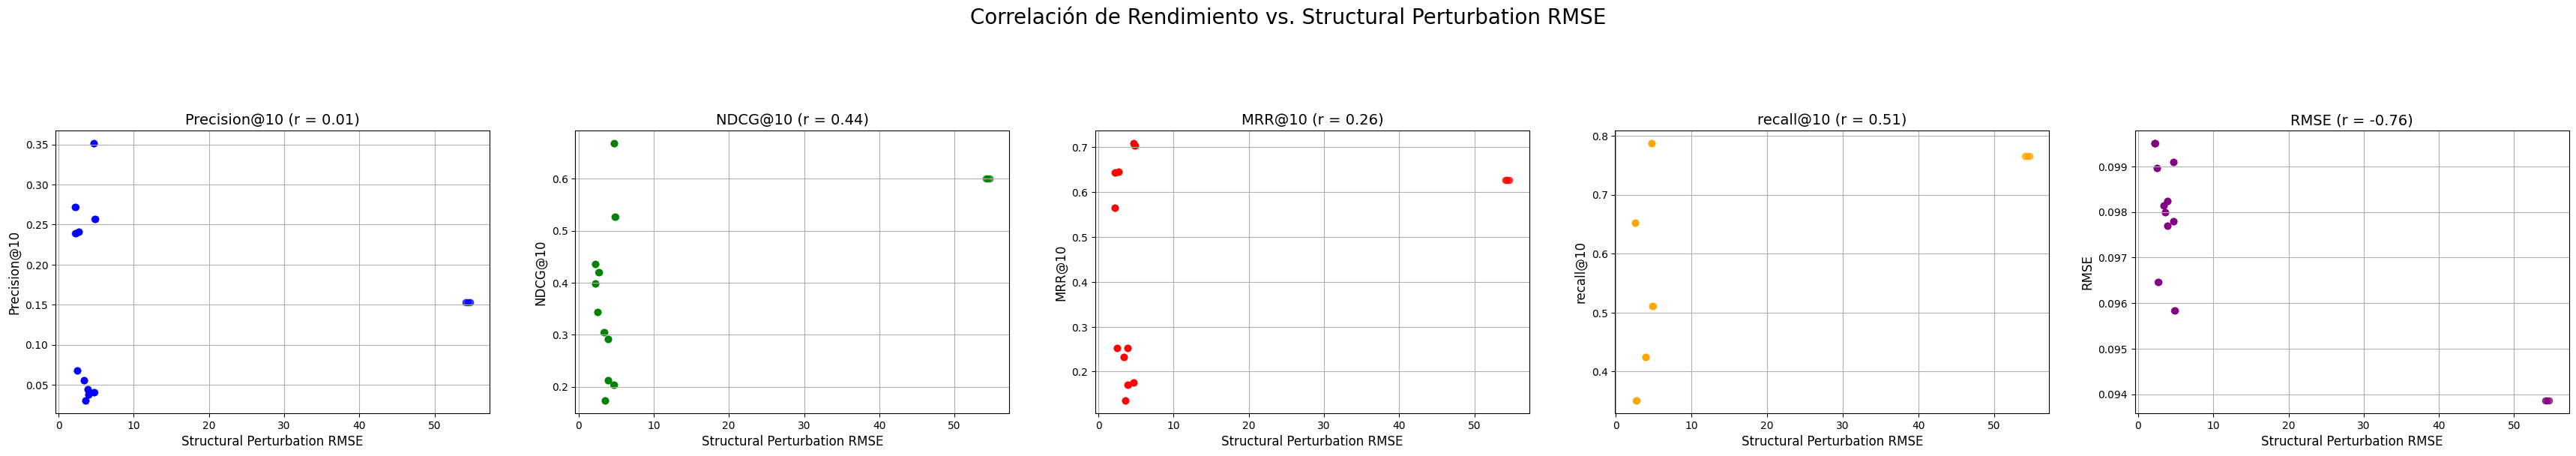

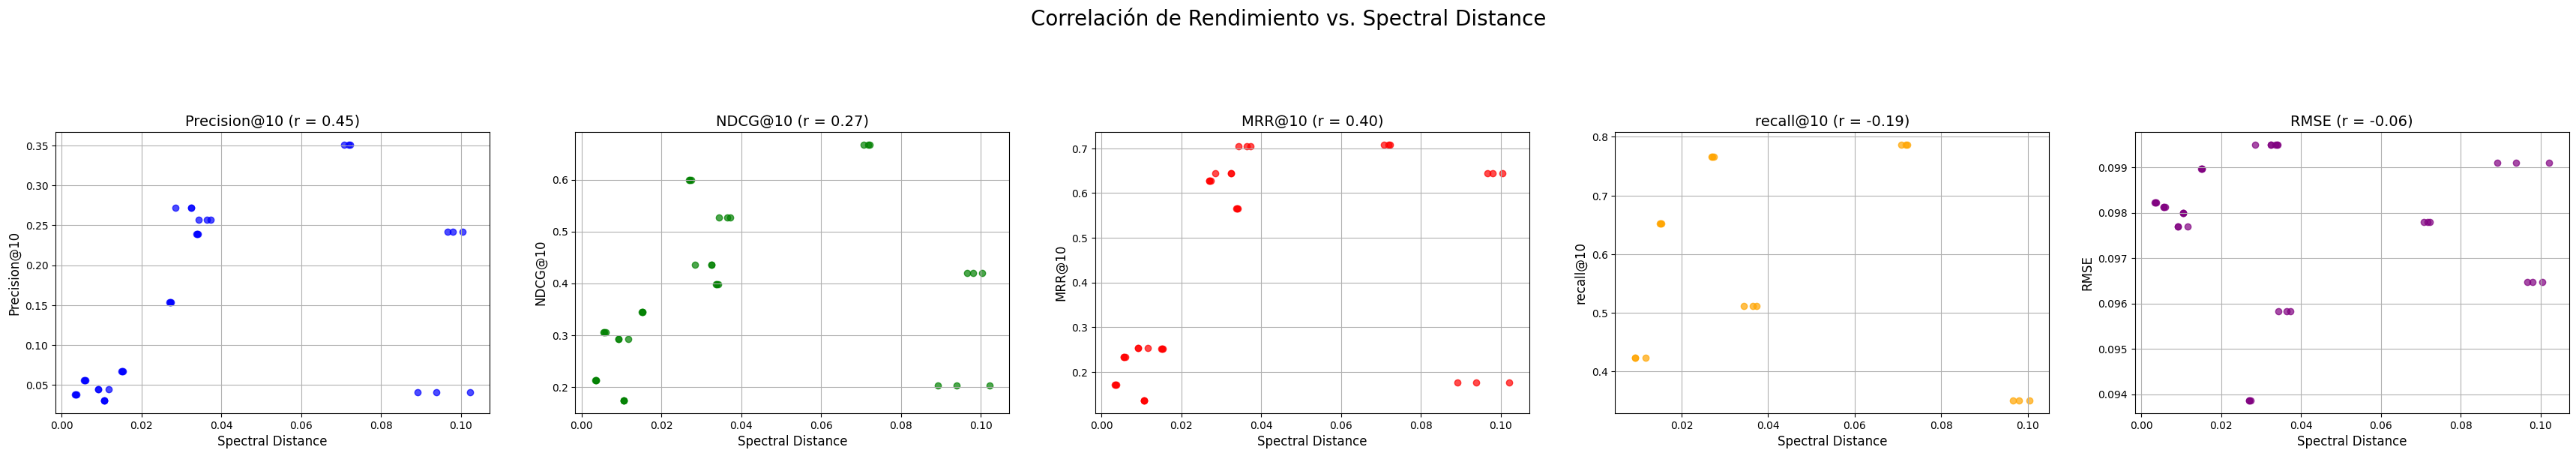

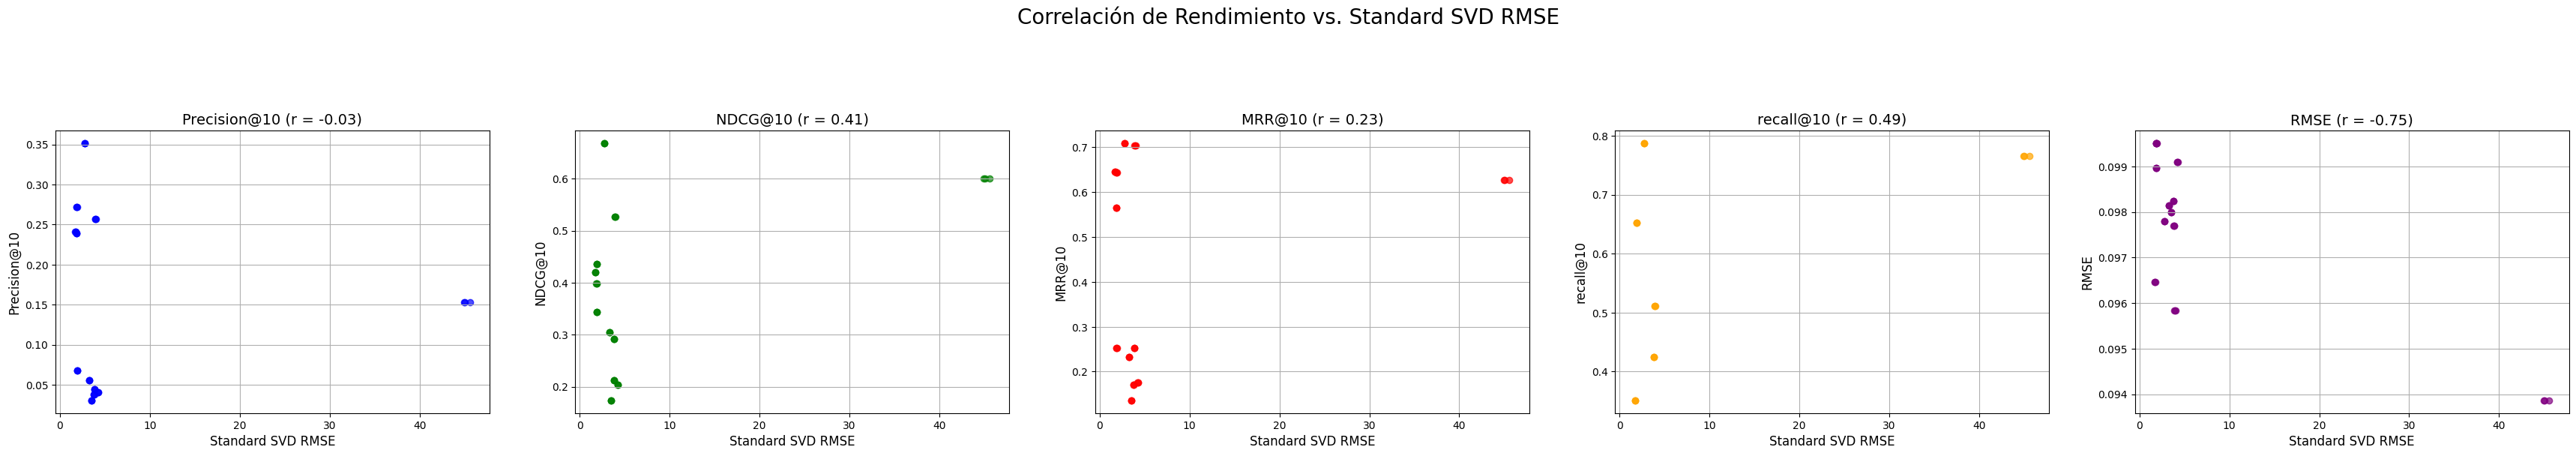

Advertencia: La métrica estructural 'Normalized RMSE' no se encontró en los datos. Saltando gráfico.


In [ ]:
## Without postprocessing of NaNs or ratings and Normalizing ratings [0,1]
## Plot of correlations between structural metrics and performance, run after having the perturbation and benchmark results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import pearsonr

# Load perturbation metrics for each dataset
try:
    perturbation_df = pd.read_csv('./structural_perturbation/perturbation_results.csv')
    # Clean dataset name to match
    perturbation_df['dataset_name'] = perturbation_df['dataset'].str.replace('.inter', '')
    print(f"Loaded {len(perturbation_df)} rows of perturbation results.")
except FileNotFoundError:
    print("Error: 'structural_perturbation/perturbation_results.csv' file not found.")

# Load the best performance metrics from benchmarks
benchmark_results_dir = './latex/'
performance_metrics = []

for _,row in perturbation_df.iterrows():
    dataset_name = row['dataset_name']
    base_dataset_name = dataset_name.split('_sample')[0]    # temporary correction, since samples were averaged for now they will use the same.
    benchmark_file = os.path.join(benchmark_results_dir, f"final_test_{base_dataset_name}_benchmark.csv")
    if os.path.exists(benchmark_file):
        try:
            df_benchmark = pd.read_csv(benchmark_file)
            
            # Extract metrics safely, using NaN if they don't exist
            best_precision = df_benchmark['precision@10'].max() if 'precision@10' in df_benchmark.columns else np.nan
            best_ndcg = df_benchmark['ndcg@10'].max() if 'ndcg@10' in df_benchmark.columns else np.nan
            best_mrr = df_benchmark['mrr@10'].max() if 'mrr@10' in df_benchmark.columns else np.nan
            best_recall = df_benchmark['recall@10'].max() if 'recall@10' in df_benchmark.columns else np.nan
            best_rmse = df_benchmark['rmse'].min() if 'rmse' in df_benchmark.columns else np.nan

            performance_metrics.append({
                'dataset_name': dataset_name,
                'Precision@10': best_precision,
                'NDCG@10': best_ndcg,
                'MRR@10': best_mrr,
                'recall@10': best_recall,
                'RMSE': best_rmse
            })
        except Exception as e:
            print(f"Warning: Could not process file {benchmark_file}: {e}")
    else:
        print(f"Warning: Benchmark file not found for {dataset_name} at {benchmark_file}")
    
performance_df = pd.DataFrame(performance_metrics)
print(f"Processed {len(performance_df)} benchmark files successfully.")

# Merge perturbation metrics with performance metrics
if not performance_df.empty:
    merged_df = pd.merge(perturbation_df, performance_df, on='dataset_name')
    print(f"Merged {len(merged_df)} datasets with their performance and perturbation metrics.")

    # Plot correlations
    # We'll use 'Spectral Distance' as the "Structural Perturbation" metric on the X-axis
    # Structural metrics to be used on the X-axis
    structural_metrics = [
        'Structural Perturbation RMSE', 
        'Spectral Distance', 
        'Standard SVD RMSE', 
        'Normalized RMSE'
    ]
    performance_metrics_to_plot = ['Precision@10', 'NDCG@10', 'MRR@10','recall@10', 'RMSE']
    colors = ['blue', 'green', 'red','orange','purple']
    
    for x_metric in structural_metrics:
        if x_metric not in merged_df.columns:
            print(f"Warning: Structural metric '{x_metric}' not found in data. Skipping plot.")
            continue

        # Create a new figure for the current structural metric
        fig, axes = plt.subplots(1, 5, figsize=(35, 6))
        fig.suptitle(f'Performance Correlation vs. {x_metric}', fontsize=20, y=1.05)
        
        # Flatten the array of axes for easy iteration
        axes = axes.flatten()

        for i, (y_metric, color) in enumerate(zip(performance_metrics_to_plot, colors)):
            ax = axes[i]
            if y_metric in merged_df.columns:
                #  Remove rows with NaN or Inf values for correlation calculation
                clean_df = merged_df[[x_metric, y_metric]].dropna()
                clean_df = clean_df[~clean_df.isin([np.inf, -np.inf]).any(axis=1)]

                # Calculate Pearson correlation
                if len(clean_df) > 1:
                    corr, _ = pearsonr(clean_df[x_metric], clean_df[y_metric])
                else:
                    corr = float('nan')
                
                # Plot
                ax.scatter(merged_df[x_metric], merged_df[y_metric], alpha=0.7, color=color)
                
                # Style and labels
                ax.set_title(f'{y_metric} (r = {corr:.2f})', fontsize=14)
                ax.set_xlabel(x_metric, fontsize=12)
                ax.set_ylabel(y_metric, fontsize=12)
                ax.grid(True)
            else:
                ax.set_title(f'{y_metric} not found')
                ax.text(0.5, 0.5, 'Data not available', ha='center', va='center')

        plt.tight_layout(pad=3.0)
        plt.show()
else:
    print("\nNo performance data found, so no plots could be generated.")


Cargadas 58 filas de resultados de perturbación.
Procesados 58 archivos de benchmark con éxito.
Se unieron 58 datasets con sus métricas de rendimiento y perturbación.


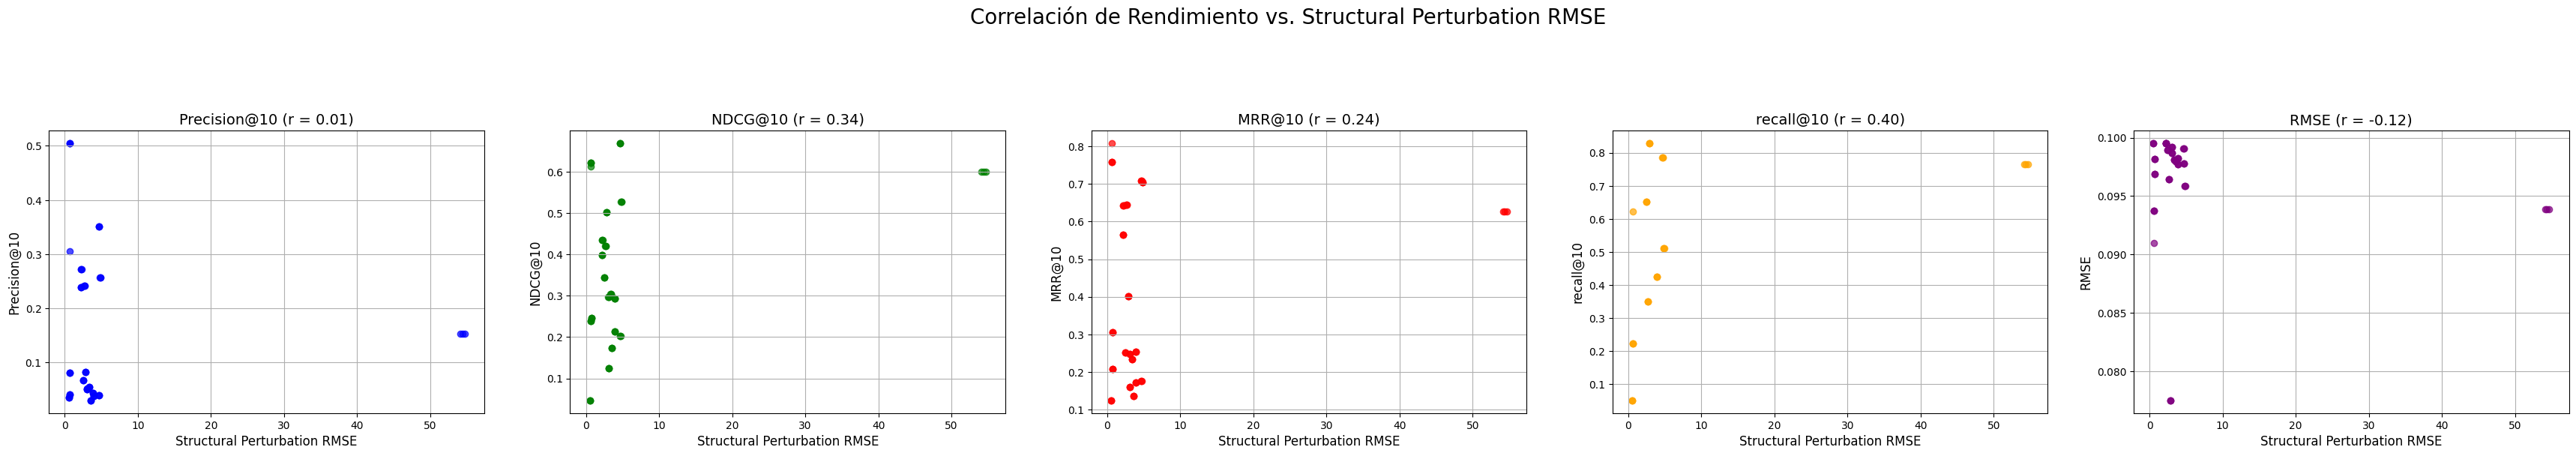

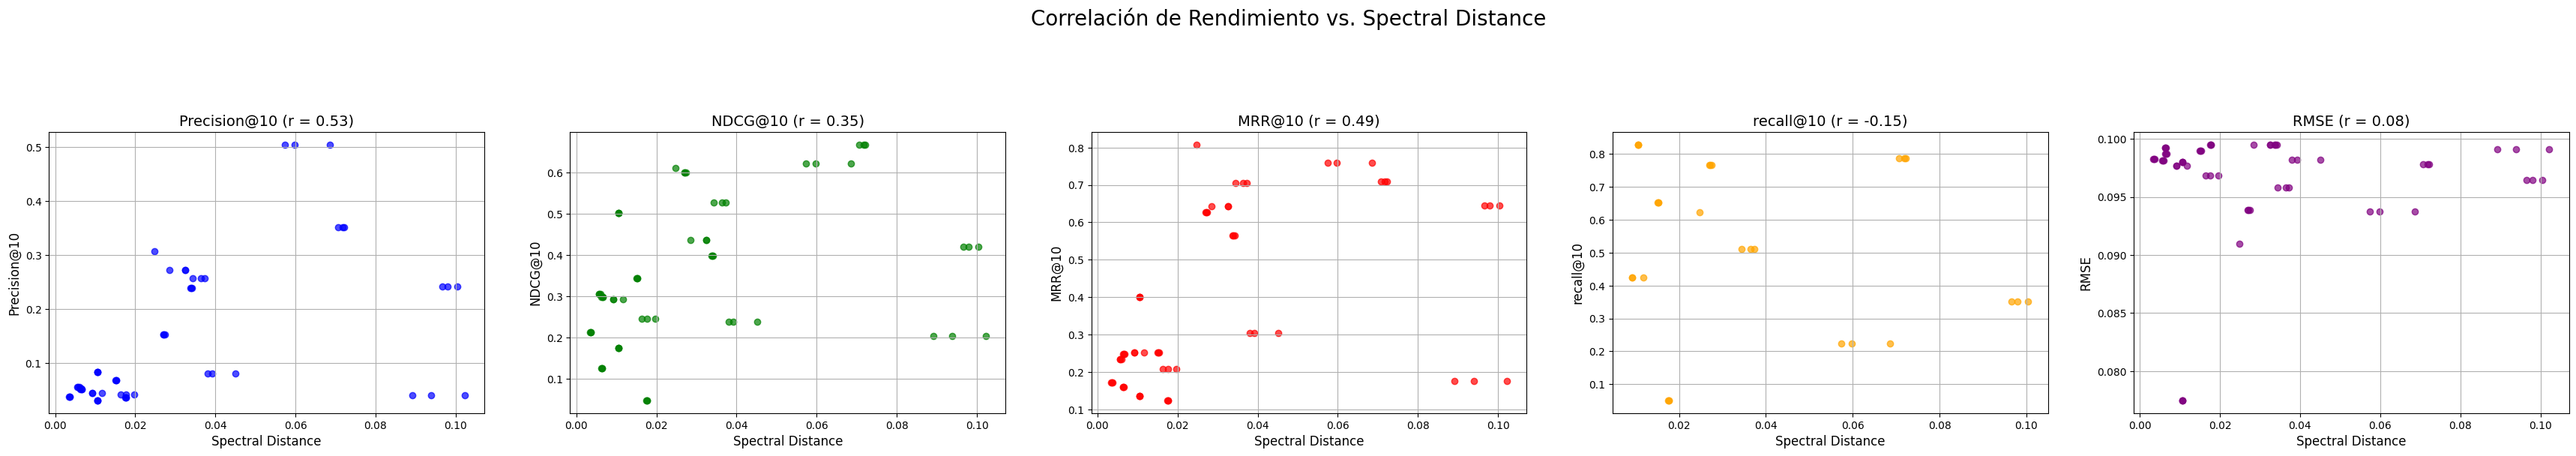

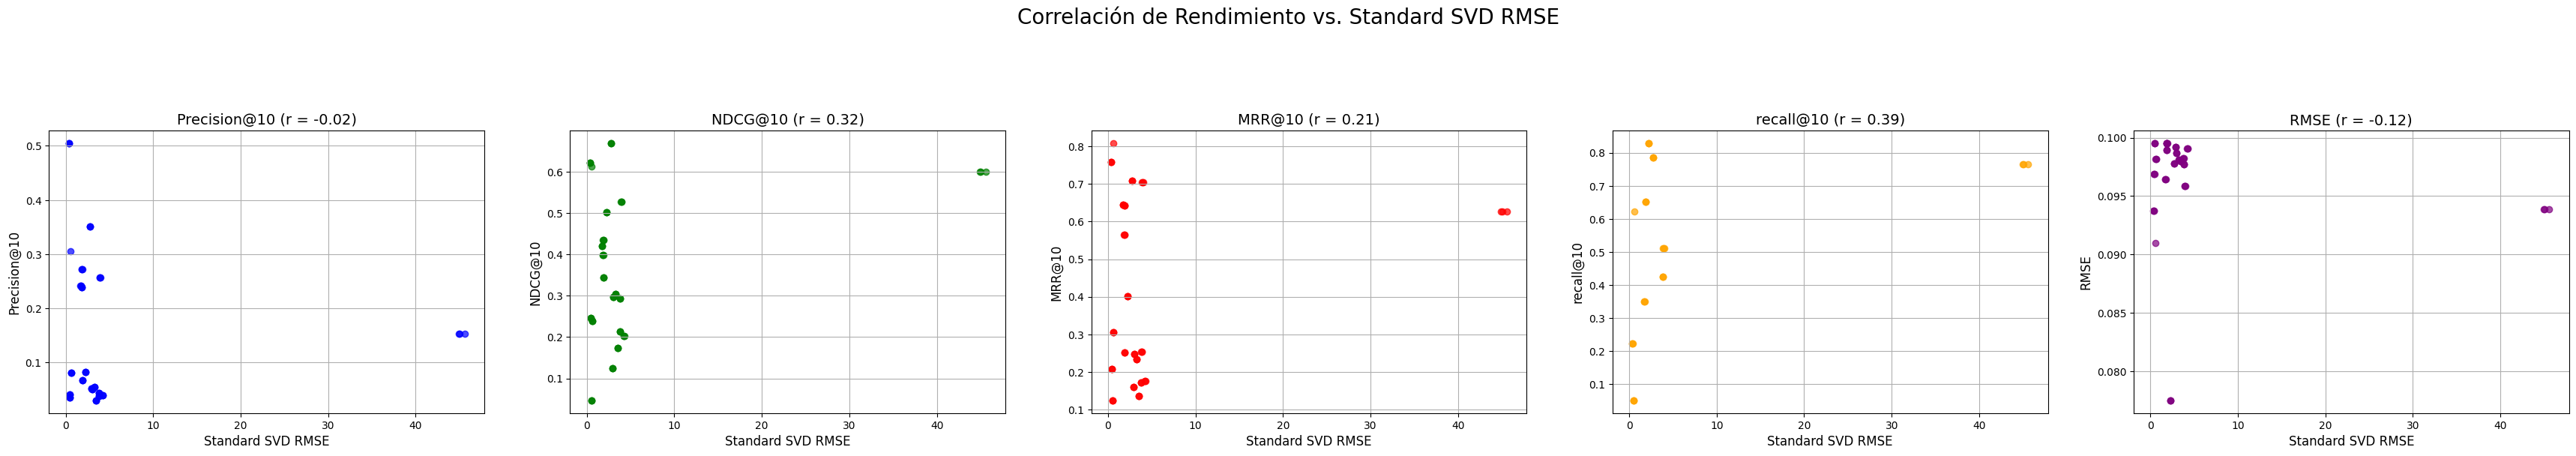

In [ ]:
## With postprocessing of NaNs or ratings and without Normalizing ratings [0,1]
## Plot of correlations between structural metrics and performance, run after having the perturbation and benchmark results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import pearsonr

# Load perturbation metrics for each dataset
try:
    perturbation_df = pd.read_csv('./structural_perturbation/perturbation_results.csv')
    # Clean dataset name to match
    perturbation_df['dataset_name'] = perturbation_df['dataset'].str.replace('.inter', '')
    print(f"Loaded {len(perturbation_df)} rows of perturbation results.")
except FileNotFoundError:
    print("Error: 'structural_perturbation/perturbation_results.csv' file not found.")

# Load the best performance metrics from benchmarks
benchmark_results_dir = './latex/'
performance_metrics = []

for _,row in perturbation_df.iterrows():
    dataset_name = row['dataset_name']
    base_dataset_name = dataset_name.split('_sample')[0]    # temporary correction, since samples were averaged for now they will use the same.
    benchmark_file = os.path.join(benchmark_results_dir, f"final_test_{base_dataset_name}_benchmark.csv")
    if os.path.exists(benchmark_file):
        try:
            df_benchmark = pd.read_csv(benchmark_file)
            
            # Extract metrics safely, using NaN if they don't exist
            best_precision = df_benchmark['precision@10'].max() if 'precision@10' in df_benchmark.columns else np.nan
            best_ndcg = df_benchmark['ndcg@10'].max() if 'ndcg@10' in df_benchmark.columns else np.nan
            best_mrr = df_benchmark['mrr@10'].max() if 'mrr@10' in df_benchmark.columns else np.nan
            best_recall = df_benchmark['recall@10'].max() if 'recall@10' in df_benchmark.columns else np.nan
            best_rmse = df_benchmark['rmse'].min() if 'rmse' in df_benchmark.columns else np.nan

            performance_metrics.append({
                'dataset_name': dataset_name,
                'Precision@10': best_precision,
                'NDCG@10': best_ndcg,
                'MRR@10': best_mrr,
                'recall@10': best_recall,
                'RMSE': best_rmse
            })
        except Exception as e:
            print(f"Warning: Could not process file {benchmark_file}: {e}")
    else:
        print(f"Warning: Benchmark file not found for {dataset_name} at {benchmark_file}")
    
performance_df = pd.DataFrame(performance_metrics)
print(f"Processed {len(performance_df)} benchmark files successfully.")

# Merge perturbation metrics with performance metrics
if not performance_df.empty:
    merged_df = pd.merge(perturbation_df, performance_df, on='dataset_name')
    print(f"Merged {len(merged_df)} datasets with their performance and perturbation metrics.")

    # Plot correlations
    # We'll use 'Spectral Distance' as the "Structural Perturbation" metric on the X-axis
    # Structural metrics to be used on the X-axis
    structural_metrics = [
        'Structural Perturbation RMSE', 
        'Spectral Distance', 
        'Standard SVD RMSE',
    ]
    performance_metrics_to_plot = ['Precision@10', 'NDCG@10', 'MRR@10','recall@10', 'RMSE']
    colors = ['blue', 'green', 'red','orange','purple']
    
    for x_metric in structural_metrics:
        if x_metric not in merged_df.columns:
            print(f"Warning: Structural metric '{x_metric}' not found in data. Skipping plot.")
            continue

        # Create a new figure for the current structural metric
        fig, axes = plt.subplots(1, 5, figsize=(35, 6))
        fig.suptitle(f'Performance Correlation vs. {x_metric}', fontsize=20, y=1.05)
        
        # Flatten the array of axes for easy iteration
        axes = axes.flatten()

        for i, (y_metric, color) in enumerate(zip(performance_metrics_to_plot, colors)):
            ax = axes[i]
            if y_metric in merged_df.columns:
                # Remove rows with NaN or Inf values for correlation calculation
                clean_df = merged_df[[x_metric, y_metric]].dropna()
                clean_df = clean_df[~clean_df.isin([np.inf, -np.inf]).any(axis=1)]

                # Calculate Pearson correlation
                if len(clean_df) > 1:
                    corr, _ = pearsonr(clean_df[x_metric], clean_df[y_metric])
                else:
                    corr = float('nan')
                
                # Plot
                ax.scatter(merged_df[x_metric], merged_df[y_metric], alpha=0.7, color=color)
                
                # Style and labels
                ax.set_title(f'{y_metric} (r = {corr:.2f})', fontsize=14)
                ax.set_xlabel(x_metric, fontsize=12)
                ax.set_ylabel(y_metric, fontsize=12)
                ax.grid(True)
            else:
                ax.set_title(f'{y_metric} not found')
                ax.text(0.5, 0.5, 'Data not available', ha='center', va='center')

        plt.tight_layout(pad=3.0)
        plt.show()
else:
    print("\nNo performance data found, so no plots could be generated.")


Cargadas 58 filas de resultados de perturbación.
Procesados 58 archivos de benchmark con éxito.
Se unieron 58 datasets con sus métricas de rendimiento y perturbación.


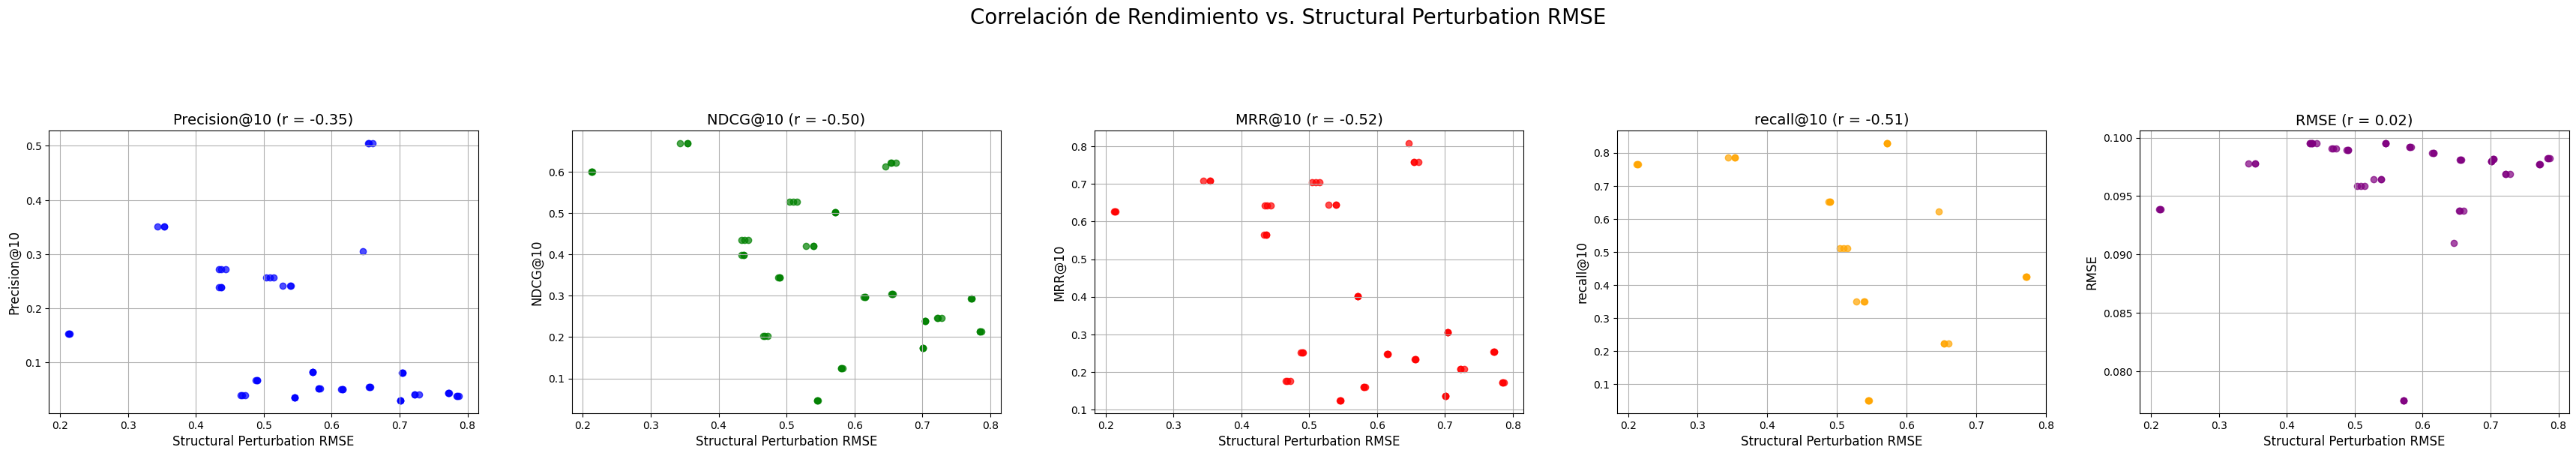

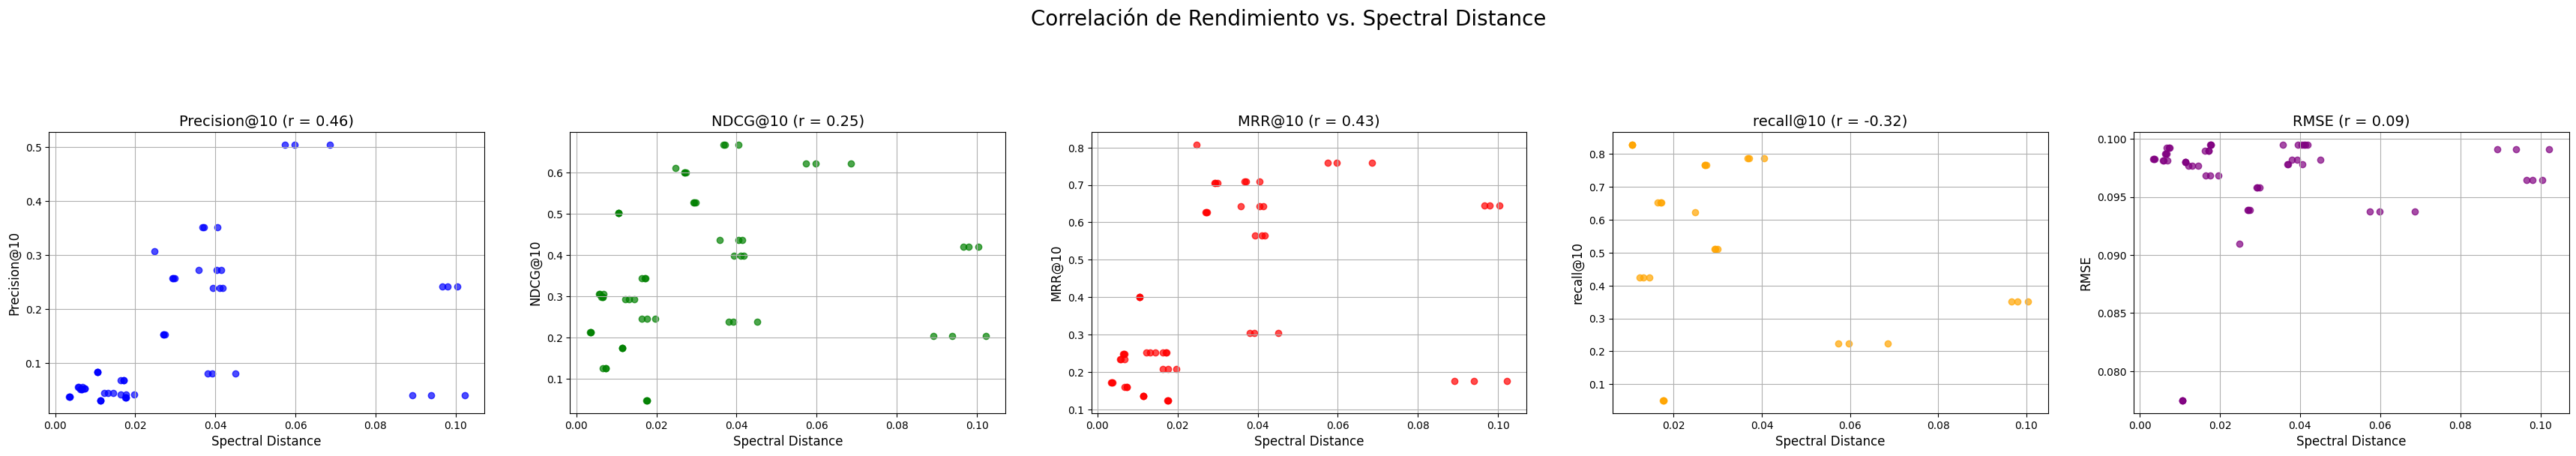

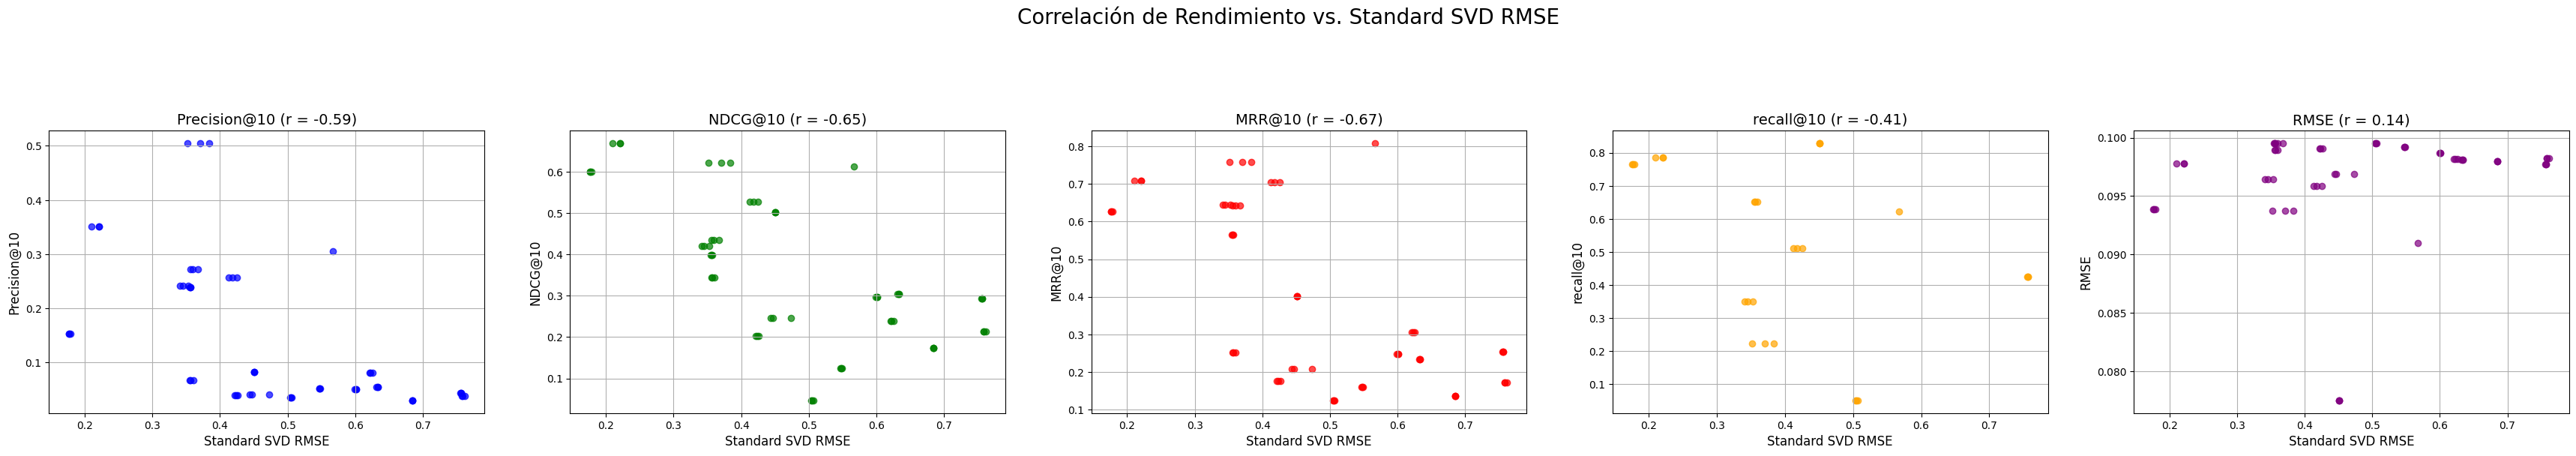

In [ ]:
## With postprocessing of NaNs or ratings and with Normalizing
## Plot of correlations between structural metrics and performance, run after having the perturbation and benchmark results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import pearsonr

# Load perturbation metrics for each dataset
try:
    perturbation_df = pd.read_csv('./structural_perturbation/perturbation_results.csv')
    # Clean dataset name to match
    perturbation_df['dataset_name'] = perturbation_df['dataset'].str.replace('.inter', '')
    print(f"Loaded {len(perturbation_df)} rows of perturbation results.")
except FileNotFoundError:
    print("Error: 'structural_perturbation/perturbation_results.csv' file not found.")

# Load the best performance metrics from benchmarks
benchmark_results_dir = './latex/'
performance_metrics = []

for _,row in perturbation_df.iterrows():
    dataset_name = row['dataset_name']
    base_dataset_name = dataset_name.split('_sample')[0]    # temporary correction, since samples were averaged for now they will use the same.
    benchmark_file = os.path.join(benchmark_results_dir, f"final_test_{base_dataset_name}_benchmark.csv")
    if os.path.exists(benchmark_file):
        try:
            df_benchmark = pd.read_csv(benchmark_file)
            
            # Extract metrics safely, using NaN if they don't exist
            best_precision = df_benchmark['precision@10'].max() if 'precision@10' in df_benchmark.columns else np.nan
            best_ndcg = df_benchmark['ndcg@10'].max() if 'ndcg@10' in df_benchmark.columns else np.nan
            best_mrr = df_benchmark['mrr@10'].max() if 'mrr@10' in df_benchmark.columns else np.nan
            best_recall = df_benchmark['recall@10'].max() if 'recall@10' in df_benchmark.columns else np.nan
            best_rmse = df_benchmark['rmse'].min() if 'rmse' in df_benchmark.columns else np.nan

            performance_metrics.append({
                'dataset_name': dataset_name,
                'Precision@10': best_precision,
                'NDCG@10': best_ndcg,
                'MRR@10': best_mrr,
                'recall@10': best_recall,
                'RMSE': best_rmse
            })
        except Exception as e:
            print(f"Warning: Could not process file {benchmark_file}: {e}")
    else:
        print(f"Warning: Benchmark file not found for {dataset_name} at {benchmark_file}")
    
performance_df = pd.DataFrame(performance_metrics)
print(f"Processed {len(performance_df)} benchmark files successfully.")

# Merge perturbation metrics with performance metrics
if not performance_df.empty:
    merged_df = pd.merge(perturbation_df, performance_df, on='dataset_name')
    print(f"Merged {len(merged_df)} datasets with their performance and perturbation metrics.")

    # Plot correlations
    # We'll use 'Spectral Distance' as the "Structural Perturbation" metric on the X-axis
    # Structural metrics to be used on the X-axis
    structural_metrics = [
        'Structural Perturbation RMSE', 
        'Spectral Distance', 
        'Standard SVD RMSE',
    ]
    performance_metrics_to_plot = ['Precision@10', 'NDCG@10', 'MRR@10','recall@10', 'RMSE']
    colors = ['blue', 'green', 'red','orange','purple']
    
    for x_metric in structural_metrics:
        if x_metric not in merged_df.columns:
            print(f"Warning: Structural metric '{x_metric}' not found in data. Skipping plot.")
            continue

        # Create a new figure for the current structural metric
        fig, axes = plt.subplots(1, 5, figsize=(35, 6))
        fig.suptitle(f'Performance Correlation vs. {x_metric}', fontsize=20, y=1.05)
        
        # Flatten the array of axes for easy iteration
        axes = axes.flatten()

        for i, (y_metric, color) in enumerate(zip(performance_metrics_to_plot, colors)):
            ax = axes[i]
            if y_metric in merged_df.columns:
                # Remove rows with NaN or Inf values for correlation calculation
                clean_df = merged_df[[x_metric, y_metric]].dropna()
                clean_df = clean_df[~clean_df.isin([np.inf, -np.inf]).any(axis=1)]

                # Calculate Pearson correlation
                if len(clean_df) > 1:
                    corr, _ = pearsonr(clean_df[x_metric], clean_df[y_metric])
                else:
                    corr = float('nan')
                
                # Plot
                ax.scatter(merged_df[x_metric], merged_df[y_metric], alpha=0.7, color=color)
                
                # Style and labels
                ax.set_title(f'{y_metric} (r = {corr:.2f})', fontsize=14)
                ax.set_xlabel(x_metric, fontsize=12)
                ax.set_ylabel(y_metric, fontsize=12)
                ax.grid(True)
            else:
                ax.set_title(f'{y_metric} not found')
                ax.text(0.5, 0.5, 'Data not available', ha='center', va='center')

        plt.tight_layout(pad=3.0)
        plt.show()
else:
    print("\nNo performance data found, so no plots could be generated.")


Cargadas 58 filas de resultados de perturbación.
Procesados 58 archivos de benchmark con éxito.
Se unieron 58 datasets con sus métricas de rendimiento y perturbación.


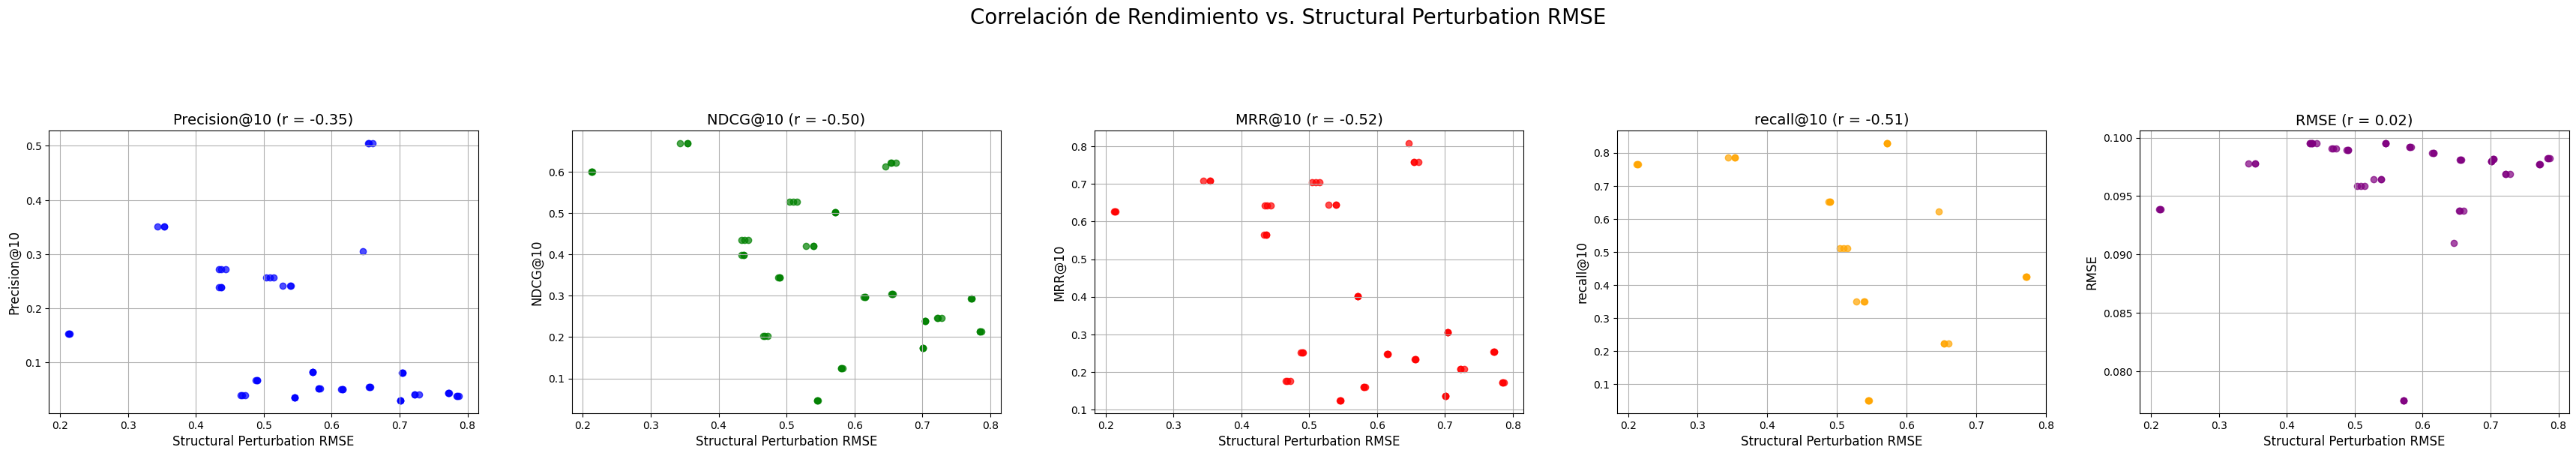

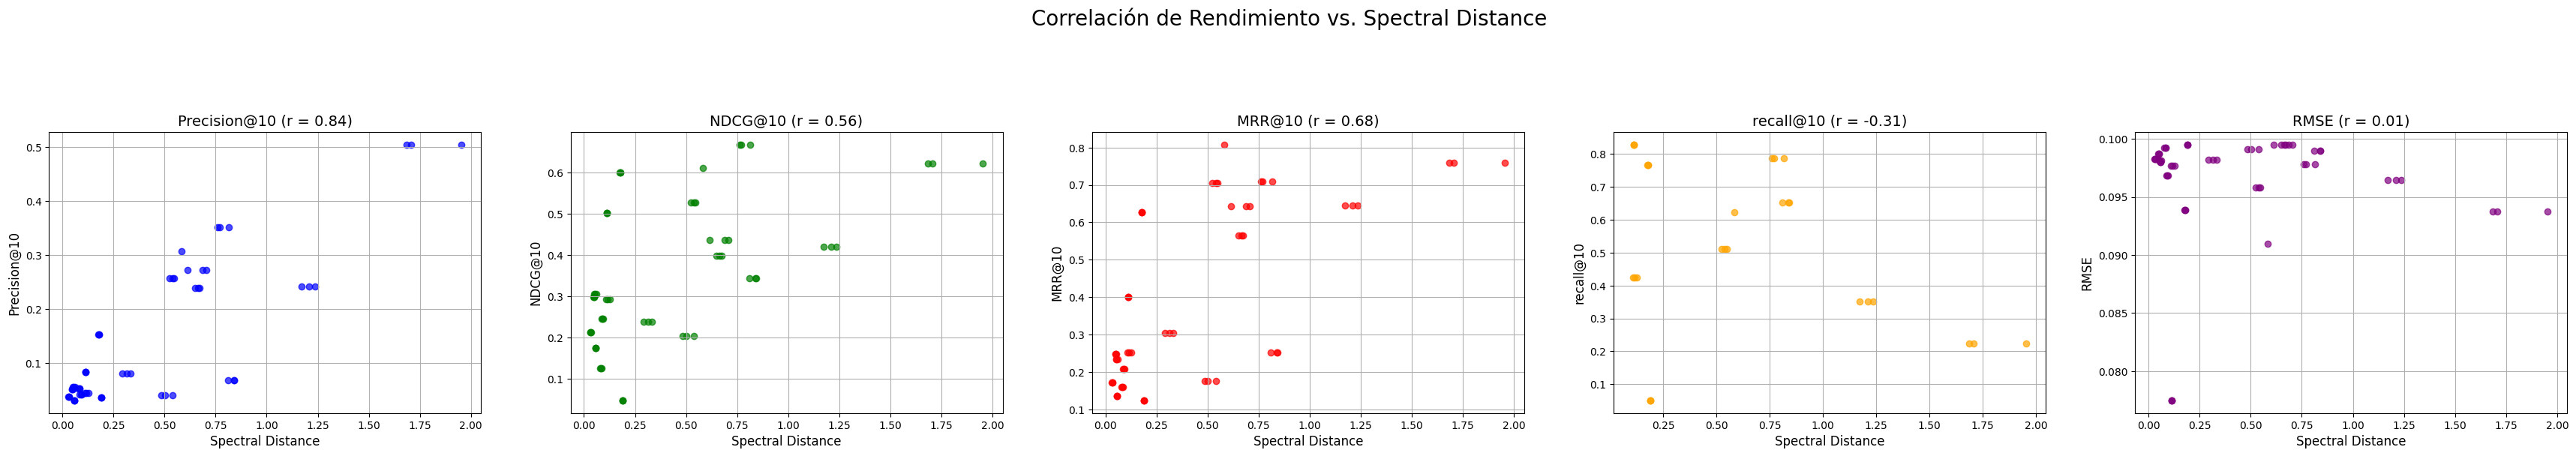

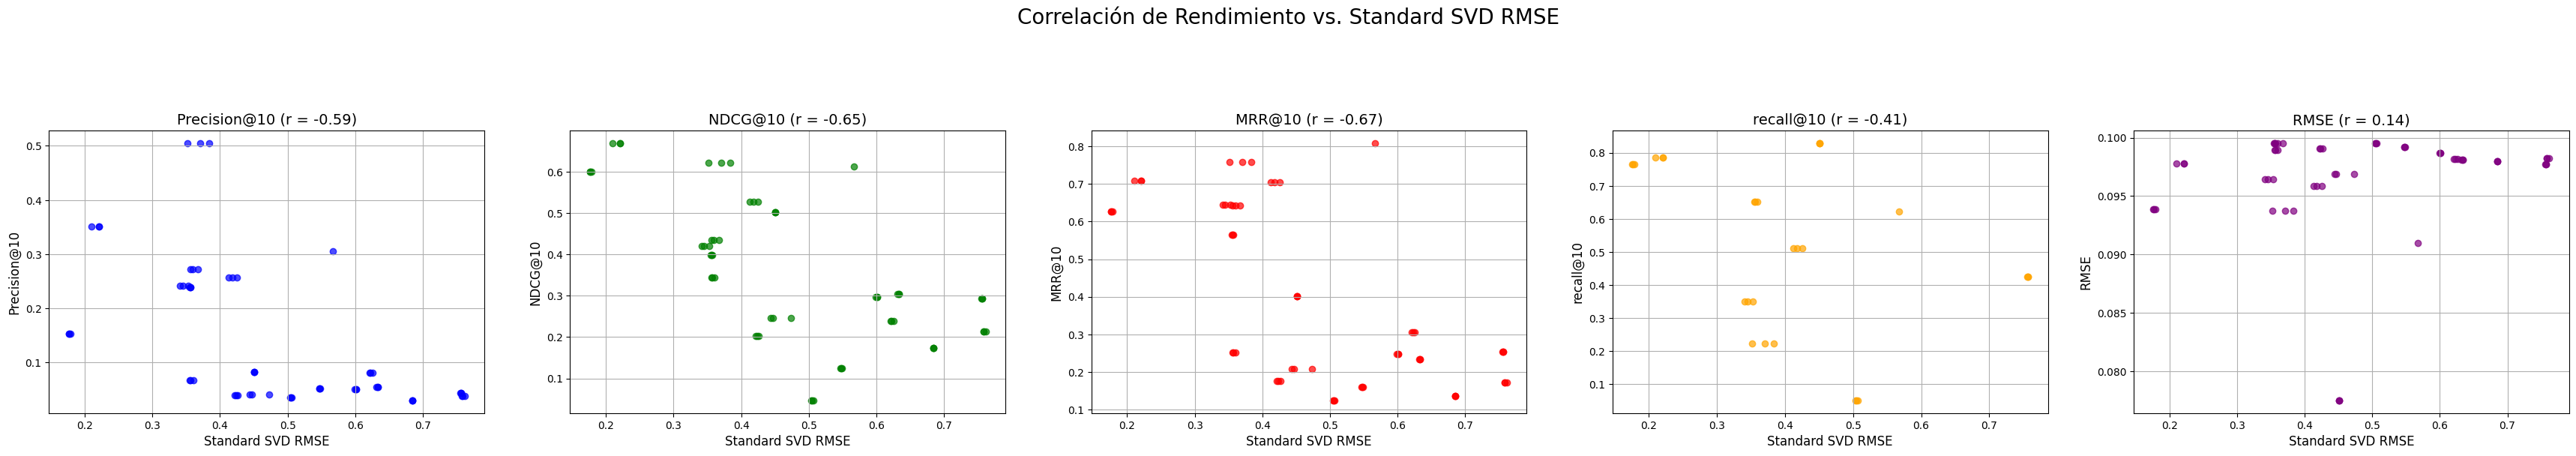

In [ ]:
## With postprocessing of NaNs or ratings and with Normalizing, Without dividing to calculate relatives errors 
## Plot of correlations between structural metrics and performance, run after having the perturbation and benchmark results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import pearsonr

# Load perturbation metrics for each dataset
try:
    perturbation_df = pd.read_csv('./structural_perturbation/perturbation_results.csv')
    # Clean dataset name to match
    perturbation_df['dataset_name'] = perturbation_df['dataset'].str.replace('.inter', '')
    print(f"Loaded {len(perturbation_df)} rows of perturbation results.")
except FileNotFoundError:
    print("Error: 'structural_perturbation/perturbation_results.csv' file not found.")

# Load the best performance metrics from benchmarks
benchmark_results_dir = './latex/'
performance_metrics = []

for _,row in perturbation_df.iterrows():
    dataset_name = row['dataset_name']
    base_dataset_name = dataset_name.split('_sample')[0]    # temporary correction, since samples were averaged for now they will use the same.
    benchmark_file = os.path.join(benchmark_results_dir, f"final_test_{base_dataset_name}_benchmark.csv")
    if os.path.exists(benchmark_file):
        try:
            df_benchmark = pd.read_csv(benchmark_file)
            
            # Extract metrics safely, using NaN if they don't exist
            best_precision = df_benchmark['precision@10'].max() if 'precision@10' in df_benchmark.columns else np.nan
            best_ndcg = df_benchmark['ndcg@10'].max() if 'ndcg@10' in df_benchmark.columns else np.nan
            best_mrr = df_benchmark['mrr@10'].max() if 'mrr@10' in df_benchmark.columns else np.nan
            best_recall = df_benchmark['recall@10'].max() if 'recall@10' in df_benchmark.columns else np.nan
            best_rmse = df_benchmark['rmse'].min() if 'rmse' in df_benchmark.columns else np.nan

            performance_metrics.append({
                'dataset_name': dataset_name,
                'Precision@10': best_precision,
                'NDCG@10': best_ndcg,
                'MRR@10': best_mrr,
                'recall@10': best_recall,
                'RMSE': best_rmse
            })
        except Exception as e:
            print(f"Warning: Could not process file {benchmark_file}: {e}")
    else:
        print(f"Warning: Benchmark file not found for {dataset_name} at {benchmark_file}")
    
performance_df = pd.DataFrame(performance_metrics)
print(f"Processed {len(performance_df)} benchmark files successfully.")

# Merge perturbation metrics with performance metrics
if not performance_df.empty:
    merged_df = pd.merge(perturbation_df, performance_df, on='dataset_name')
    print(f"Merged {len(merged_df)} datasets with their performance and perturbation metrics.")

    # Plot correlations
    # We'll use 'Spectral Distance' as the "Structural Perturbation" metric on the X-axis
    # Structural metrics to be used on the X-axis
    structural_metrics = [
        'Structural Perturbation RMSE', 
        'Spectral Distance', 
        'Standard SVD RMSE',
    ]
    performance_metrics_to_plot = ['Precision@10', 'NDCG@10', 'MRR@10','recall@10', 'RMSE']
    colors = ['blue', 'green', 'red','orange','purple']
    
    for x_metric in structural_metrics:
        if x_metric not in merged_df.columns:
            print(f"Warning: Structural metric '{x_metric}' not found in data. Skipping plot.")
            continue

        # Create a new figure for the current structural metric
        fig, axes = plt.subplots(1, 5, figsize=(35, 6))
        fig.suptitle(f'Performance Correlation vs. {x_metric}', fontsize=20, y=1.05)
        
        # Flatten the array of axes for easy iteration
        axes = axes.flatten()

        for i, (y_metric, color) in enumerate(zip(performance_metrics_to_plot, colors)):
            ax = axes[i]
            if y_metric in merged_df.columns:
                # Remove rows with NaN or Inf values for correlation calculation
                clean_df = merged_df[[x_metric, y_metric]].dropna()
                clean_df = clean_df[~clean_df.isin([np.inf, -np.inf]).any(axis=1)]

                # Calculate Pearson correlation
                if len(clean_df) > 1:
                    corr, _ = pearsonr(clean_df[x_metric], clean_df[y_metric])
                else:
                    corr = float('nan')
                
                # Plot
                ax.scatter(merged_df[x_metric], merged_df[y_metric], alpha=0.7, color=color)
                
                # Style and labels
                ax.set_title(f'{y_metric} (r = {corr:.2f})', fontsize=14)
                ax.set_xlabel(x_metric, fontsize=12)
                ax.set_ylabel(y_metric, fontsize=12)
                ax.grid(True)
            else:
                ax.set_title(f'{y_metric} not found')
                ax.text(0.5, 0.5, 'Data not available', ha='center', va='center')

        plt.tight_layout(pad=3.0)
        plt.show()
else:
    print("\nNo performance data found, so no plots could be generated.")


Cargadas 67 filas de resultados de perturbación.
Procesados 67 archivos de benchmark con éxito.
Se unieron 67 datasets con sus métricas de rendimiento y perturbación.


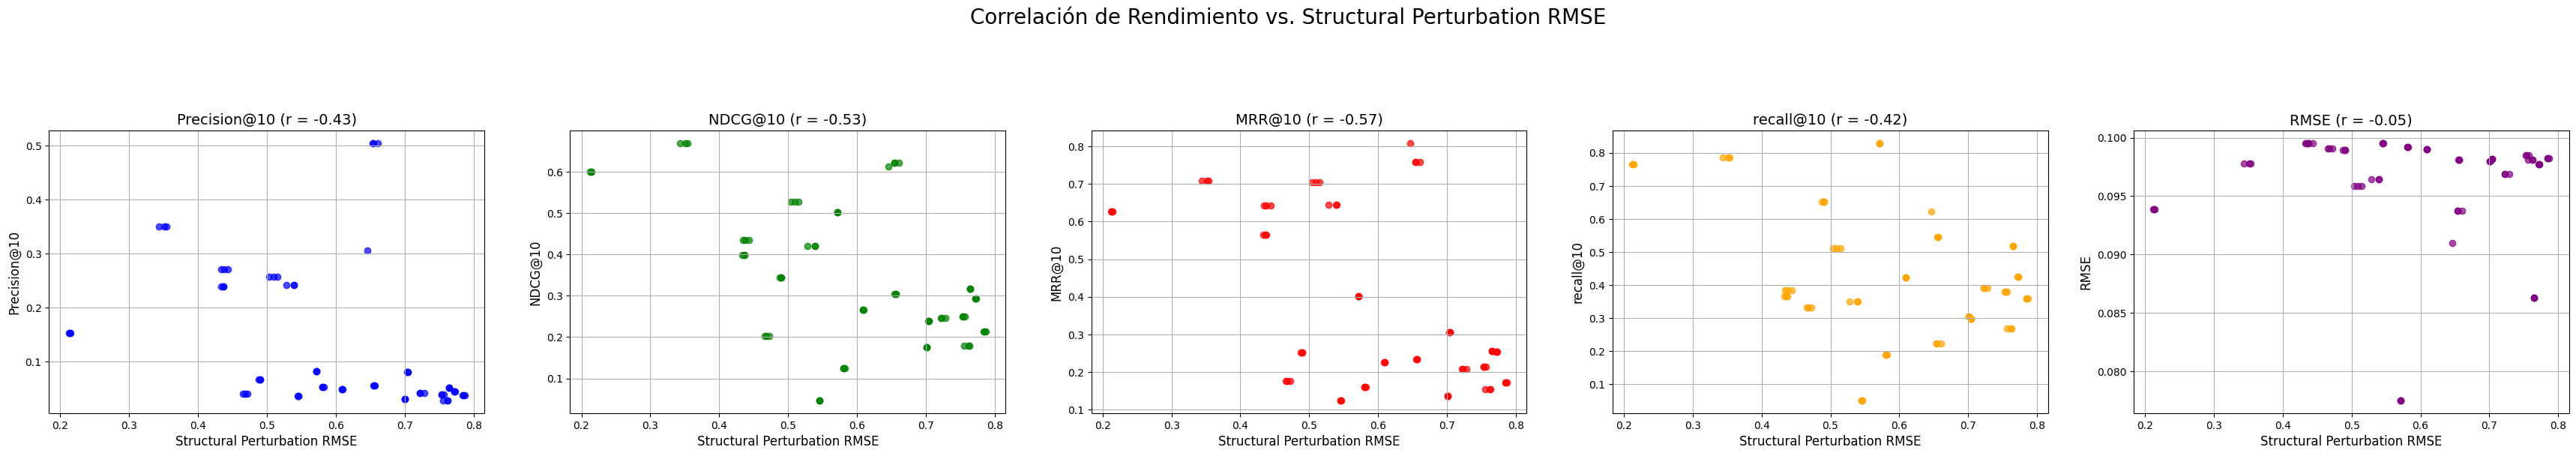

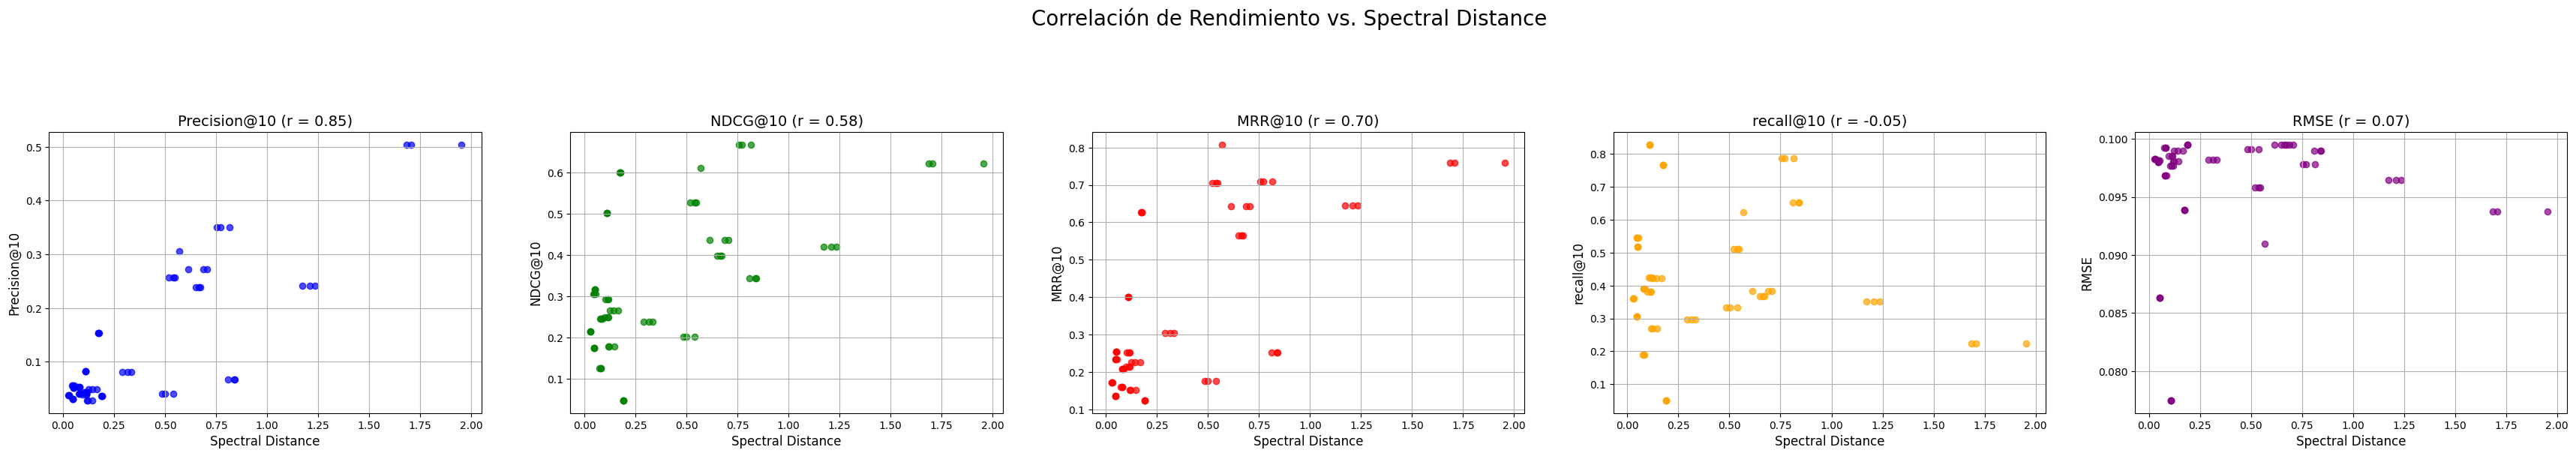

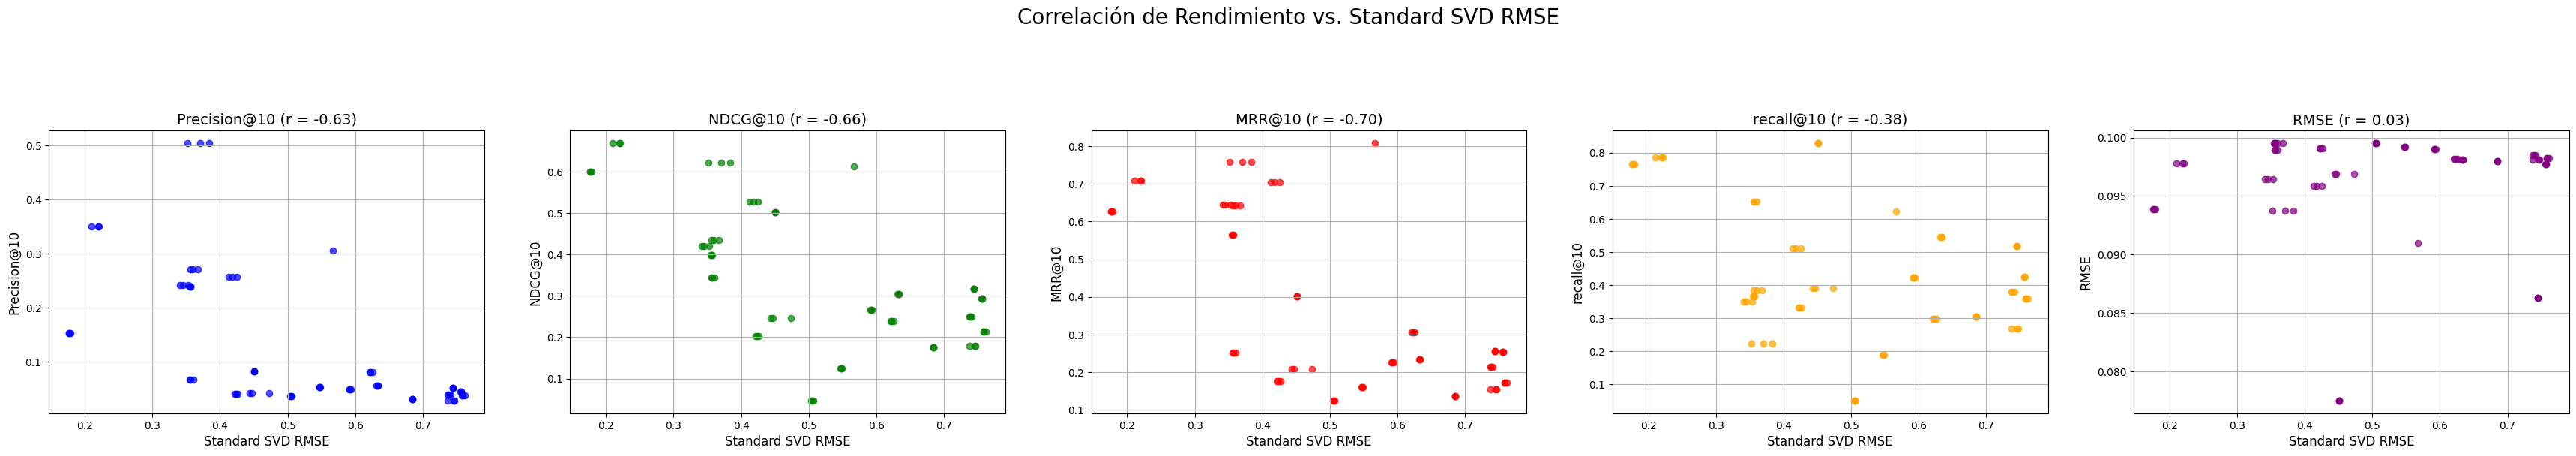

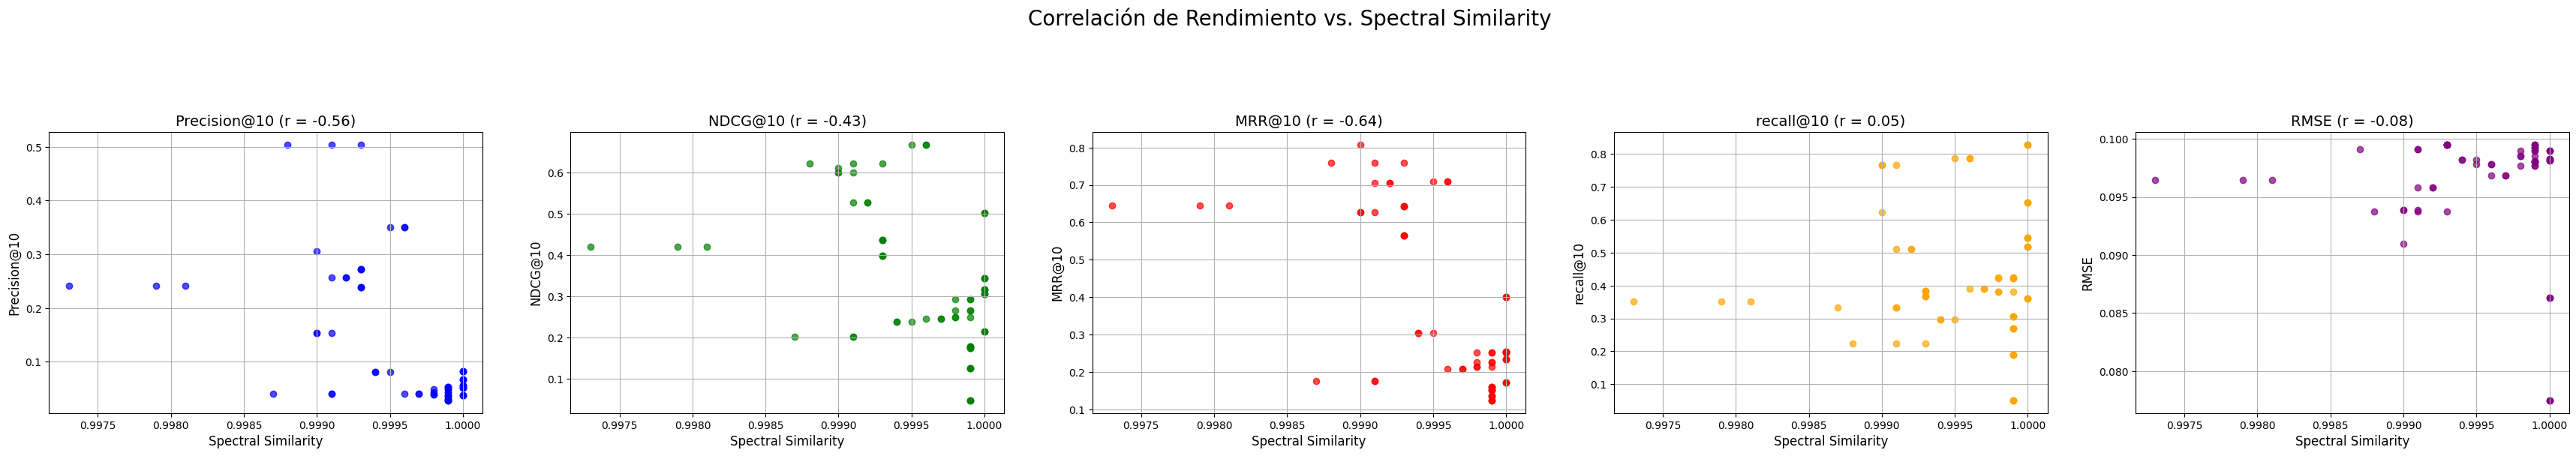

In [ ]:
## With postprocessing of NaNs or ratings and with Normalizing, Without dividing to calculate relatives errors and sorting lambdas from highest to lowest
## Plot of correlations between structural metrics and performance, run after having the perturbation and benchmark results
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import pearsonr

# Load perturbation metrics for each dataset
try:
    perturbation_df = pd.read_csv('./structural_perturbation/perturbation_results.csv')
    # Clean dataset name to match
    perturbation_df['dataset_name'] = perturbation_df['dataset'].str.replace('.inter', '')
    print(f"Loaded {len(perturbation_df)} rows of perturbation results.")
except FileNotFoundError:
    print("Error: 'structural_perturbation/perturbation_results.csv' file not found.")

# Load the best performance metrics from benchmarks
benchmark_results_dir = './latex/'
performance_metrics = []

for _,row in perturbation_df.iterrows():
    dataset_name = row['dataset_name']
    base_dataset_name = dataset_name.split('_sample')[0]    # temporary correction, since samples were averaged for now they will use the same.
    benchmark_file = os.path.join(benchmark_results_dir, f"final_test_{base_dataset_name}_benchmark.csv")
    if os.path.exists(benchmark_file):
        try:
            df_benchmark = pd.read_csv(benchmark_file)
            
            # Extract metrics safely, using NaN if they don't exist
            best_precision = df_benchmark['precision@10'].max() if 'precision@10' in df_benchmark.columns else np.nan
            best_ndcg = df_benchmark['ndcg@10'].max() if 'ndcg@10' in df_benchmark.columns else np.nan
            best_mrr = df_benchmark['mrr@10'].max() if 'mrr@10' in df_benchmark.columns else np.nan
            best_recall = df_benchmark['recall@10'].max() if 'recall@10' in df_benchmark.columns else np.nan
            best_rmse = df_benchmark['rmse'].min() if 'rmse' in df_benchmark.columns else np.nan

            performance_metrics.append({
                'dataset_name': dataset_name,
                'Precision@10': best_precision,
                'NDCG@10': best_ndcg,
                'MRR@10': best_mrr,
                'recall@10': best_recall,
                'RMSE': best_rmse
            })
        except Exception as e:
            print(f"Warning: Could not process file {benchmark_file}: {e}")
    else:
        print(f"Warning: Benchmark file not found for {dataset_name} at {benchmark_file}")
    
performance_df = pd.DataFrame(performance_metrics)
print(f"Processed {len(performance_df)} benchmark files successfully.")

# Merge perturbation metrics with performance metrics
if not performance_df.empty:
    merged_df = pd.merge(perturbation_df, performance_df, on='dataset_name')
    print(f"Merged {len(merged_df)} datasets with their performance and perturbation metrics.")

    # Plot correlations
    # We'll use 'Spectral Distance' as the "Structural Perturbation" metric on the X-axis
    # Structural metrics to be used on the X-axis
    structural_metrics = [
        'Structural Perturbation RMSE', 
        'Spectral Distance', 
        'Standard SVD RMSE',
        'Spectral Similarity'
    ]
    performance_metrics_to_plot = ['Precision@10', 'NDCG@10', 'MRR@10','recall@10', 'RMSE']
    colors = ['blue', 'green', 'red','orange','purple']
    
    for x_metric in structural_metrics:
        if x_metric not in merged_df.columns:
            print(f"Warning: Structural metric '{x_metric}' not found in data. Skipping plot.")
            continue

        # Create a new figure for the current structural metric
        fig, axes = plt.subplots(1, 5, figsize=(35, 6))
        fig.suptitle(f'Performance Correlation vs. {x_metric}', fontsize=20, y=1.05)
        
        # Flatten the array of axes for easy iteration
        axes = axes.flatten()

        for i, (y_metric, color) in enumerate(zip(performance_metrics_to_plot, colors)):
            ax = axes[i]
            if y_metric in merged_df.columns:
                # Remove rows with NaN or Inf values for correlation calculation
                clean_df = merged_df[[x_metric, y_metric]].dropna()
                clean_df = clean_df[~clean_df.isin([np.inf, -np.inf]).any(axis=1)]

                # Calculate Pearson correlation
                if len(clean_df) > 1:
                    corr, _ = pearsonr(clean_df[x_metric], clean_df[y_metric])
                else:
                    corr = float('nan')
                
                # Plot
                ax.scatter(merged_df[x_metric], merged_df[y_metric], alpha=0.7, color=color)
                
                # Style and labels
                ax.set_title(f'{y_metric} (r = {corr:.2f})', fontsize=14)
                ax.set_xlabel(x_metric, fontsize=12)
                ax.set_ylabel(y_metric, fontsize=12)
                ax.grid(True)
            else:
                ax.set_title(f'{y_metric} not found')
                ax.text(0.5, 0.5, 'Data not available', ha='center', va='center')

        plt.tight_layout(pad=3.0)
        plt.show()
else:
    print("\nNo performance data found, so no plots could be generated.")


In [ ]:
import pandas as pd
import os
import numpy as np

# 1. Load perturbation metrics (Structural Perturbation)
perturbation_file = './structural_perturbation/perturbation_results.csv'
output_csv = 'datasets_metrics_summary.csv'

if not os.path.exists(perturbation_file):
    print(f"Error: Perturbation file not found at {perturbation_file}")
else:
    perturbation_df = pd.read_csv(perturbation_file)
    # Create auxiliary column for merge, removing the .inter extension
    perturbation_df['dataset_name'] = perturbation_df['dataset'].str.replace('.inter', '')
    
    print(f"Loaded {len(perturbation_df)} rows of structural metrics.")

    # 2. Collect performance metrics (Benchmarks)
    benchmark_results_dir = './latex/'
    performance_metrics = []

    print("Processing benchmark files...")
    
    for _, row in perturbation_df.iterrows():
        dataset_name = row['dataset_name']
        # Logic to find the benchmark file (based on your plotting code)
        # Assumes the base name (without _sampleX) is used for the benchmark
        base_dataset_name = dataset_name.split('_sample')[0]
        benchmark_file = os.path.join(benchmark_results_dir, f"final_test_{base_dataset_name}_benchmark.csv")
        
        if os.path.exists(benchmark_file):
            try:
                df_benchmark = pd.read_csv(benchmark_file)
                
                # Extract the BEST available metrics
                # Maximize accuracy metrics
                best_precision = df_benchmark['precision@10'].max() if 'precision@10' in df_benchmark.columns else np.nan
                best_ndcg = df_benchmark['ndcg@10'].max() if 'ndcg@10' in df_benchmark.columns else np.nan
                best_mrr = df_benchmark['mrr@10'].max() if 'mrr@10' in df_benchmark.columns else np.nan
                best_recall = df_benchmark['recall@10'].max() if 'recall@10' in df_benchmark.columns else np.nan
                
                # Minimize error metrics
                best_rmse = df_benchmark['rmse'].min() if 'rmse' in df_benchmark.columns else np.nan

                performance_metrics.append({
                    'dataset_name': dataset_name,
                    'Best_Precision@10': best_precision,
                    'Best_NDCG@10': best_ndcg,
                    'Best_MRR@10': best_mrr,
                    'Best_Recall@10': best_recall,
                    'Best_RMSE': best_rmse
                })
            except Exception as e:
                print(f"  Warning: Error reading {benchmark_file}: {e}")
        else:
            # If no specific benchmark exists, NaN will be filled during the merge
            print(f"  Warning: No benchmark found for {dataset_name}")

    # 3. Merge and Save
    if performance_metrics:
        performance_df = pd.DataFrame(performance_metrics)
        
        # Merge: dataset + structural + performance
        # Use 'left' to keep all perturbation datasets even if they don't have a benchmark
        full_df = pd.merge(perturbation_df, performance_df, on='dataset_name', how='left')
        
        # Organize columns: Dataset, Structural Metrics, Performance Metrics
        cols_structural = [c for c in perturbation_df.columns if c not in ['dataset', 'dataset_name']]
        cols_performance = [c for c in performance_df.columns if c != 'dataset_name']
        
        final_cols = ['dataset'] + cols_structural + cols_performance
        
        # Filter only the columns that exist in full_df
        final_cols = [c for c in final_cols if c in full_df.columns]
        
        full_df = full_df[final_cols]
        
        full_df.to_csv(output_csv, index=False)
        print(f"\nFile generated successfully: {output_csv}")
        print(f"Dimensions: {full_df.shape}")
        print(full_df.head())
    else:
        print("No performance metrics found to merge.")

Cargadas 67 filas de métricas estructurales.
Procesando archivos de benchmark...

Archivo generado exitosamente: datasets_metrics_summary.csv
Dimensiones: (67, 10)
                              dataset  Structural Perturbation RMSE  \
0          Amazon_Books_sample1.inter                        0.7628   
1          Amazon_Books_sample2.inter                        0.7622   
2          Amazon_Books_sample3.inter                        0.7558   
3  Amazon_Movies_and_TV_sample1.inter                        0.7568   
4  Amazon_Movies_and_TV_sample2.inter                        0.7536   

   Spectral Distance  Standard SVD RMSE  Spectral Similarity  \
0             0.1220             0.7468               0.9999   
1             0.1176             0.7455               0.9999   
2             0.1452             0.7372               0.9999   
3             0.0976             0.7412               0.9999   
4             0.1128             0.7389               0.9998   

   Best_Precision@10  Be

Eliminando columnas duplicadas de perf_df para evitar conflictos: ['Structural Perturbation RMSE', 'Spectral Distance', 'Standard SVD RMSE']
Datos unidos: 1675 filas.

 ANALIZANDO MÉTRICA ESTRUCTURAL: Structural Perturbation RMSE
Generando Heatmap: Structural Perturbation RMSE vs Best_Precision@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: structural_perturbation_rmse_Precision10.png


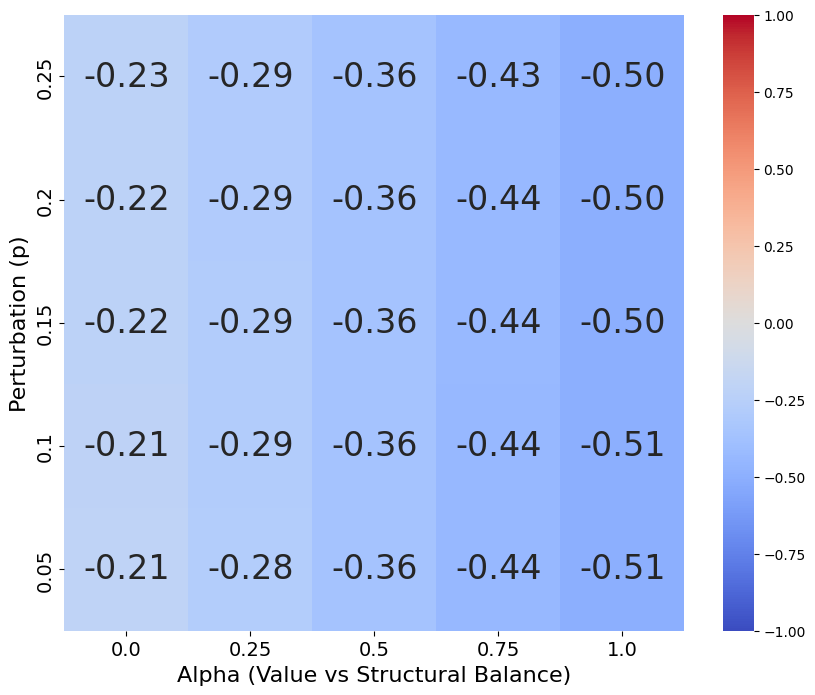

Generando Heatmap: Structural Perturbation RMSE vs Best_NDCG@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: structural_perturbation_rmse_NDCG10.png


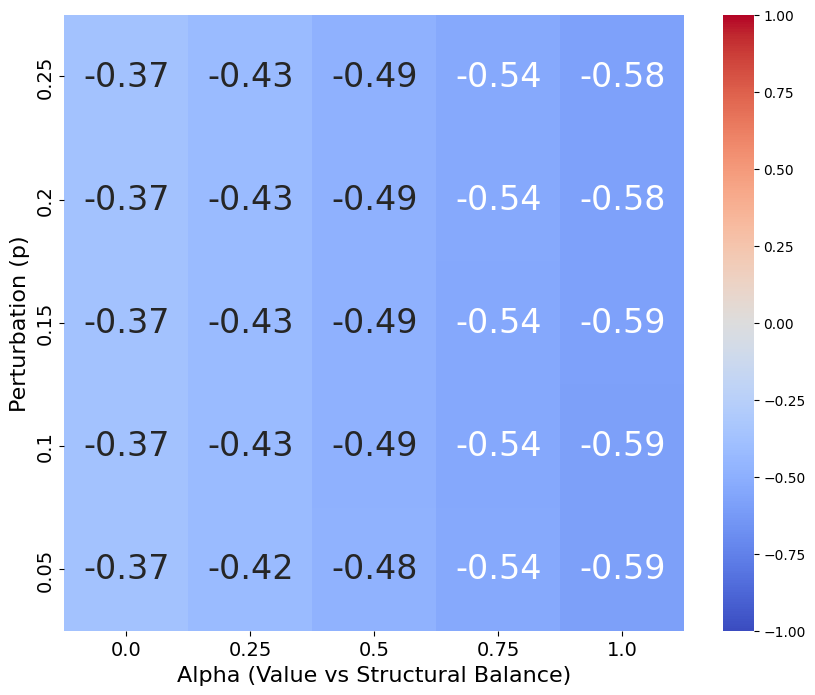

Generando Heatmap: Structural Perturbation RMSE vs Best_MRR@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: structural_perturbation_rmse_MRR10.png


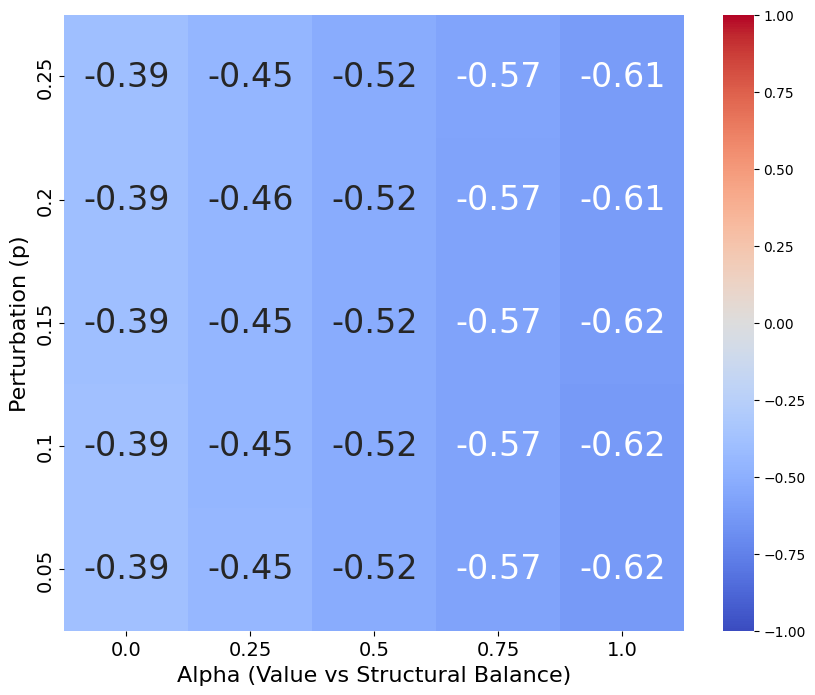

Generando Heatmap: Structural Perturbation RMSE vs Best_Recall@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: structural_perturbation_rmse_Recall10.png


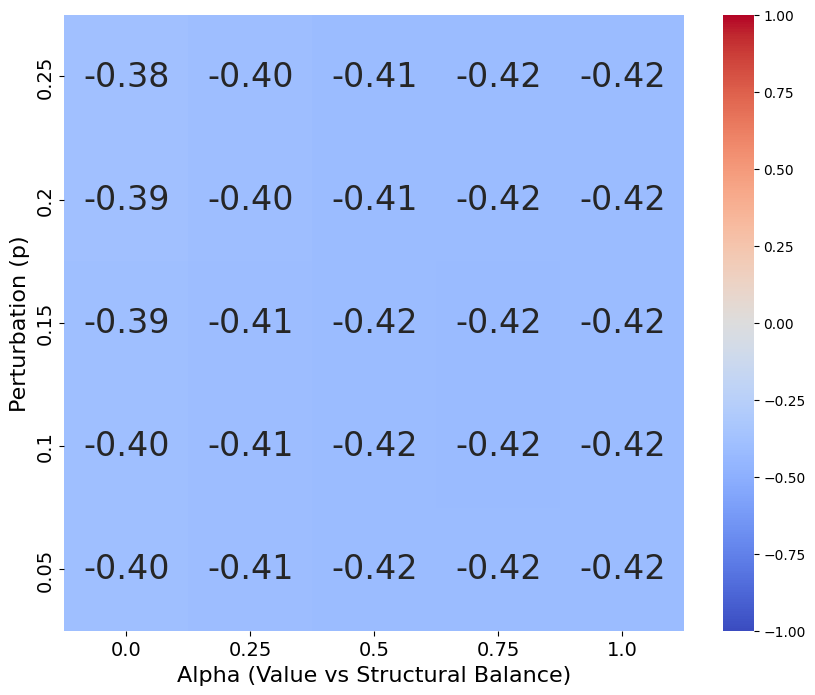

Generando Heatmap: Structural Perturbation RMSE vs Best_RMSE...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: structural_perturbation_rmse_RMSE.png


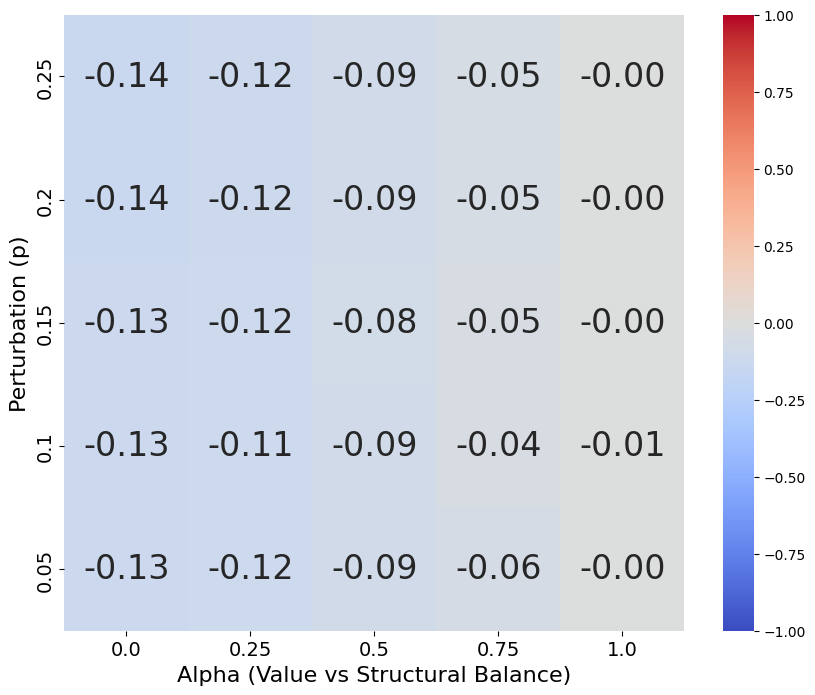


 ANALIZANDO MÉTRICA ESTRUCTURAL: Spectral Distance
Generando Heatmap: Spectral Distance vs Best_Precision@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: spectral_distance_Precision10.png


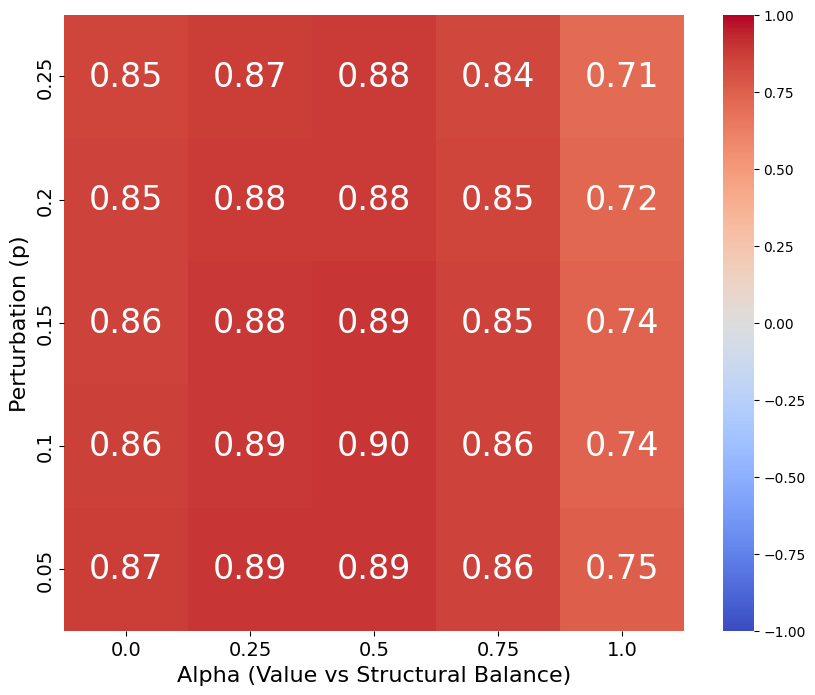

Generando Heatmap: Spectral Distance vs Best_NDCG@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: spectral_distance_NDCG10.png


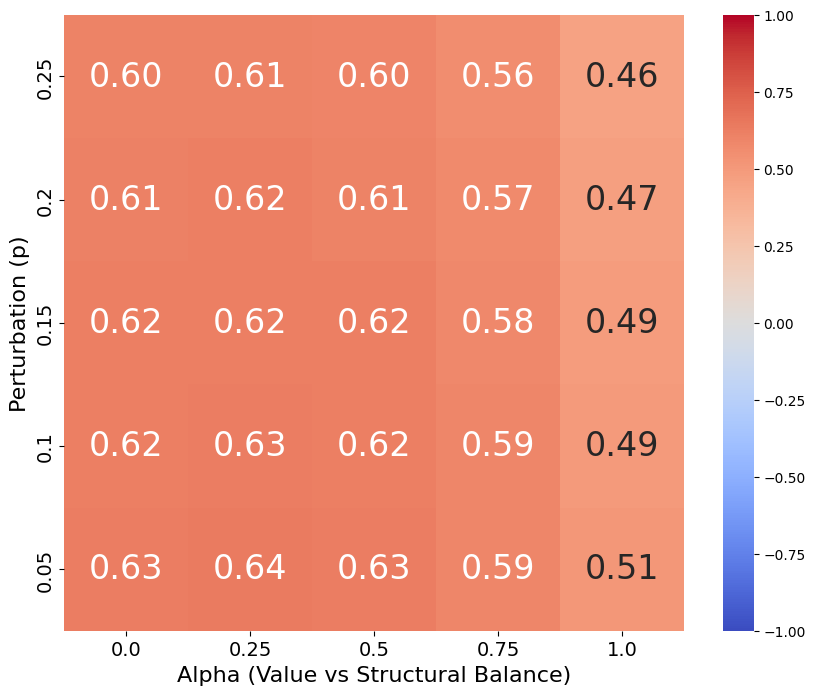

Generando Heatmap: Spectral Distance vs Best_MRR@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: spectral_distance_MRR10.png


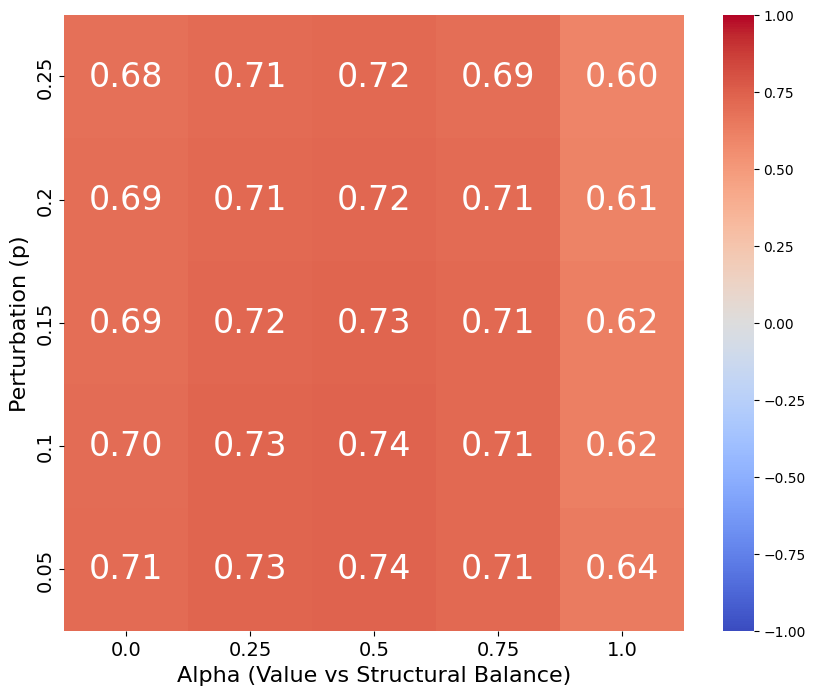

Generando Heatmap: Spectral Distance vs Best_Recall@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: spectral_distance_Recall10.png


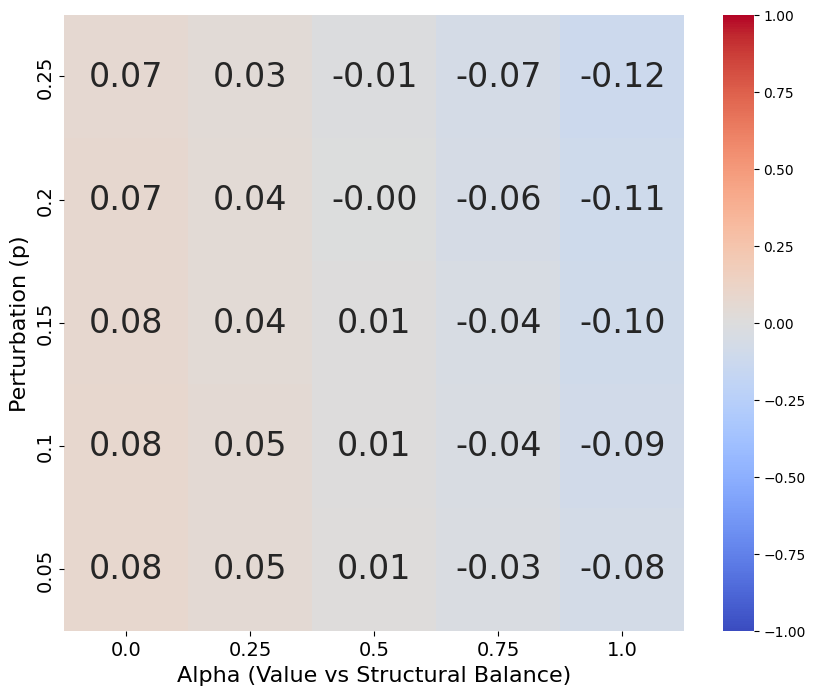

Generando Heatmap: Spectral Distance vs Best_RMSE...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: spectral_distance_RMSE.png


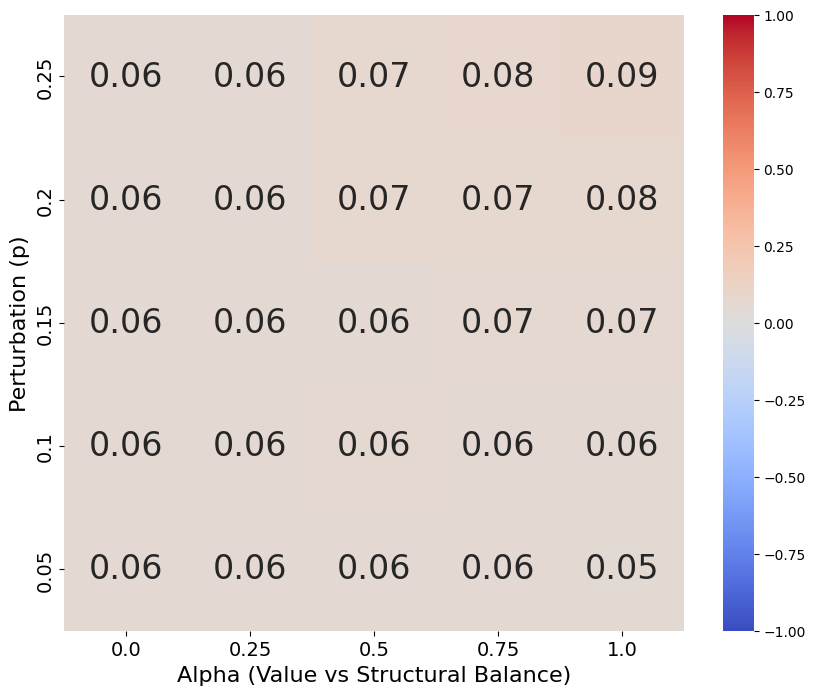


 ANALIZANDO MÉTRICA ESTRUCTURAL: Standard SVD RMSE
Generando Heatmap: Standard SVD RMSE vs Best_Precision@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: standard_svd_rmse_Precision10.png


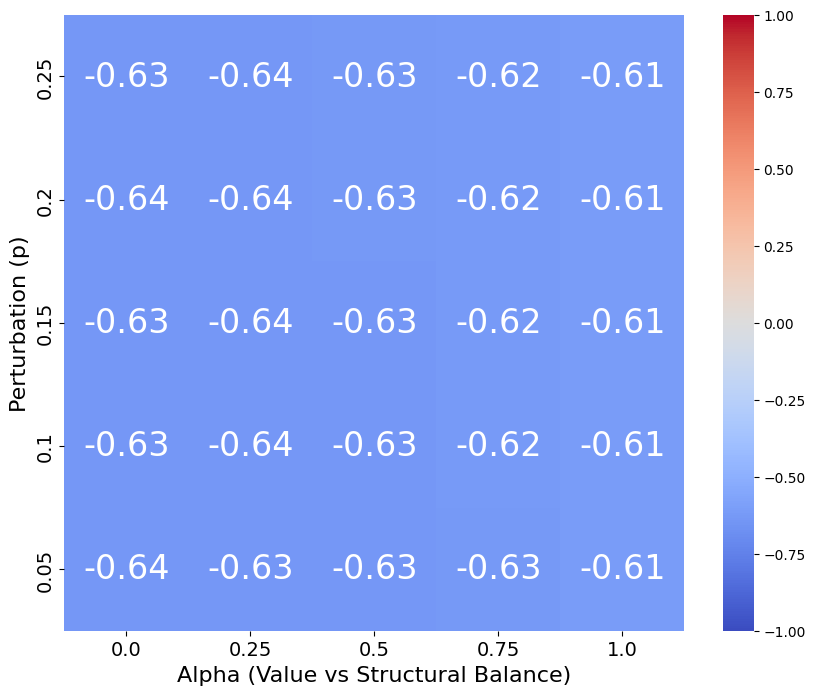

Generando Heatmap: Standard SVD RMSE vs Best_NDCG@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: standard_svd_rmse_NDCG10.png


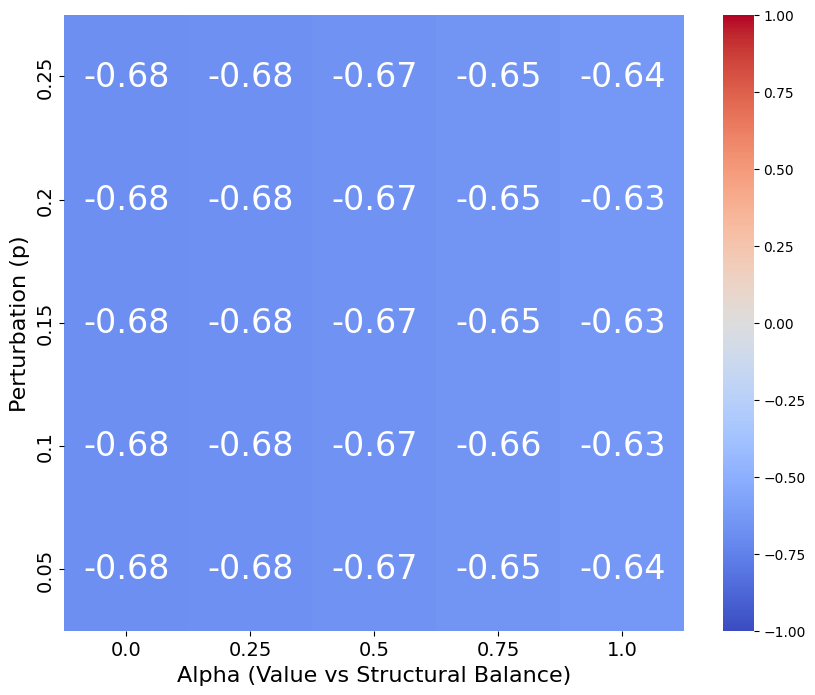

Generando Heatmap: Standard SVD RMSE vs Best_MRR@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: standard_svd_rmse_MRR10.png


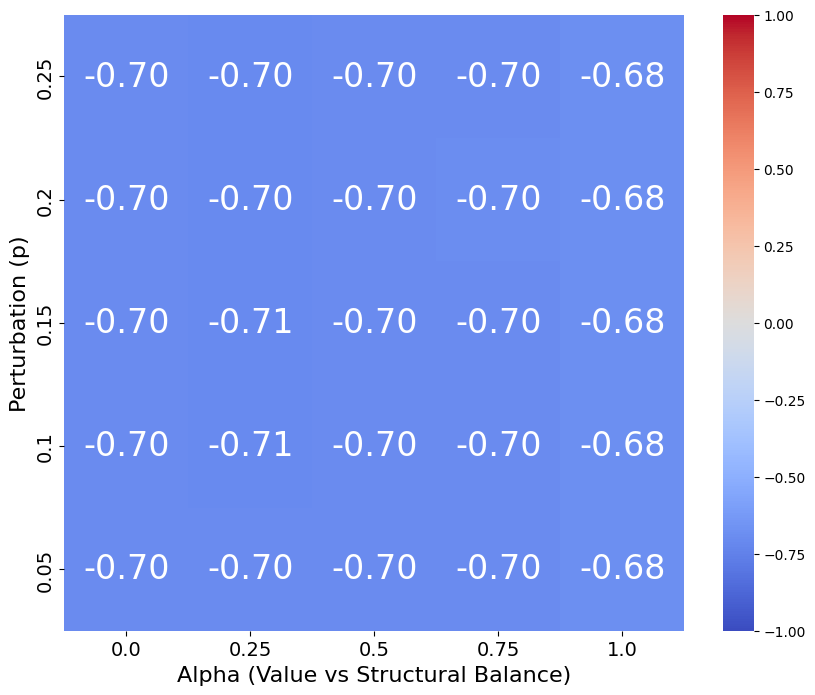

Generando Heatmap: Standard SVD RMSE vs Best_Recall@10...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: standard_svd_rmse_Recall10.png


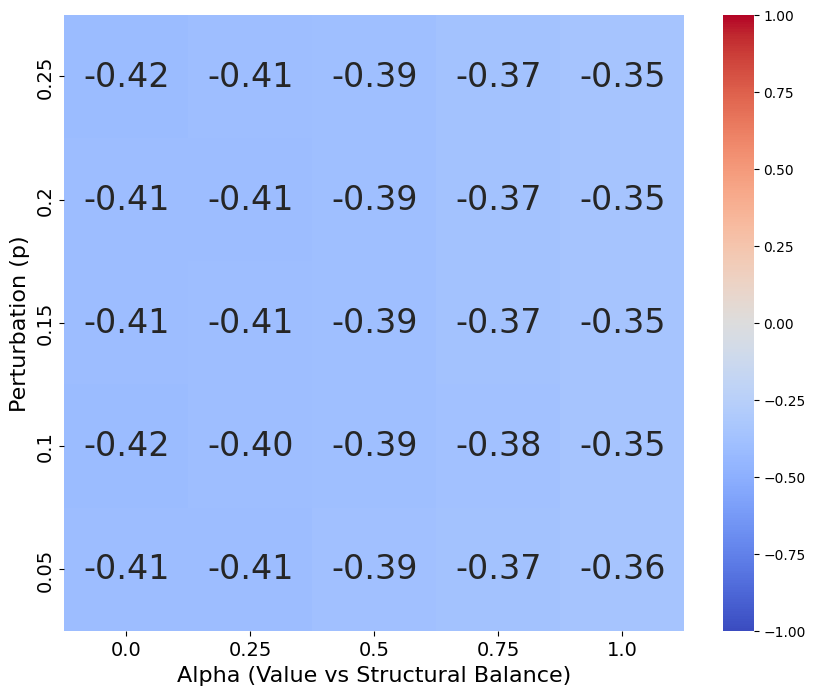

Generando Heatmap: Standard SVD RMSE vs Best_RMSE...


/tmp/ipykernel_8084/625040548.py:56: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  heatmap_data = merged_full.groupby(['p', 'alpha']).apply(


  -> Guardado: standard_svd_rmse_RMSE.png


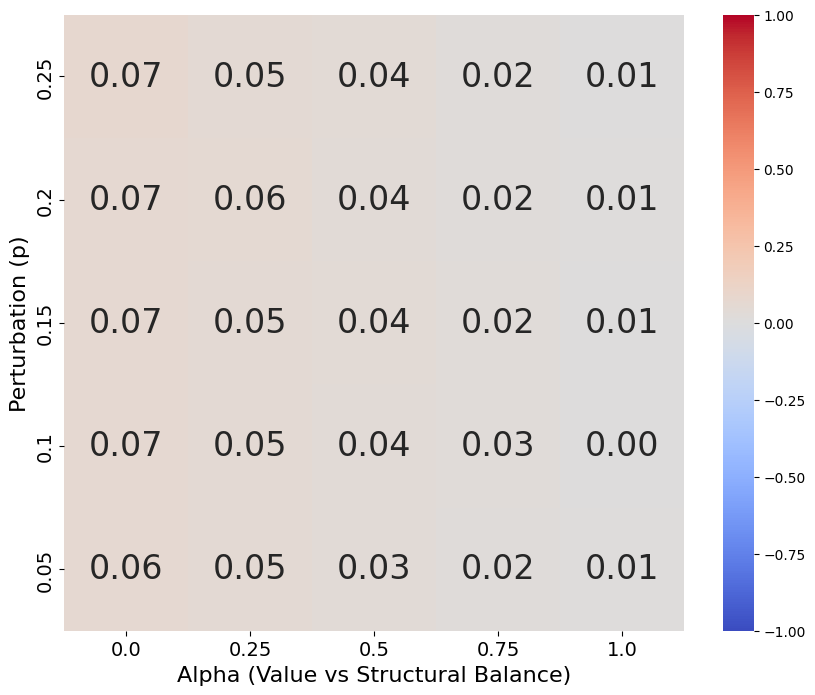

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import os

# 1. Load perturbation results (Ablation Study)
ablation_df = pd.read_csv('./structural_perturbation/ablation_results.csv')

# 2. Load performance metrics (Adjust filename if needed)
perf_df = pd.read_csv('datasets_metrics_summary.csv')

# Clean dataset names to ensure correct merge
perf_df['dataset_name'] = perf_df['dataset'].str.replace('.inter', '')

# Identify columns that already exist in ablation_df to avoid duplication (prevents _x, _y suffixes)
cols_to_drop = [col for col in ablation_df.columns if col in perf_df.columns and col != 'dataset_name']
if cols_to_drop:
    print(f"Dropping duplicate columns from perf_df to avoid conflicts: {cols_to_drop}")
    perf_df = perf_df.drop(columns=cols_to_drop)

# 3. Merge both DataFrames
merged_full = pd.merge(ablation_df, perf_df, on='dataset_name', how='inner')

print(f"Merged data: {len(merged_full)} rows.")

# 4. Define performance metrics to analyze
target_perf_metrics = ['Best_Precision@10','Best_NDCG@10',  'Best_MRR@10', 'Best_Recall@10', 'Best_RMSE']
target_struct_metrics = ['Structural Perturbation RMSE', 'Spectral Distance', 'Standard SVD RMSE']

# Base directory to save graphs
base_graph_dir = './grafos'

# 5. Generate Heatmaps
for struct_metric in target_struct_metrics:
    if struct_metric not in merged_full.columns:
        print(f"Warning: '{struct_metric}' not found in data. Skipping...")
        continue
    
    # Create clean folder name (e.g., Spectral Distance -> spectral_distance)
    struct_clean_name = struct_metric.replace(' ', '_').lower()
    metric_dir = os.path.join(base_graph_dir, struct_clean_name)
    os.makedirs(metric_dir, exist_ok=True)

    print(f"\n" + "="*60)
    print(f" ANALYZING STRUCTURAL METRIC: {struct_metric}")
    print("="*60)

    for perf_metric in target_perf_metrics:
        if perf_metric not in merged_full.columns:
            continue
        print(f"Generating Heatmap: {struct_metric} vs {perf_metric}...")
        try:
            # Calculate correlation for each pair (p, alpha)
            heatmap_data = merged_full.groupby(['p', 'alpha']).apply(
                lambda x: pearsonr(x[struct_metric], x[perf_metric])[0]
                if len(x) > 1 else np.nan
            ).reset_index(name='correlation')

            # Pivot to matrix format (Heatmap)
            heatmap_matrix = heatmap_data.pivot(index='p', columns='alpha', values='correlation')

            # Plot
            plt.figure(figsize=(10, 8))
            sns.heatmap(heatmap_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1,
                        annot_kws={"size": 24})
            
            plt.ylabel("Perturbation (p)", fontsize=16)
            plt.xlabel("Alpha (Value vs Structural Balance)", fontsize=16)

            # Increase the size of the tick labels
            plt.xticks(fontsize=14)
            plt.yticks(fontsize=14)

            # Invert Y-axis so that p increases downward or adjust as preferred
            plt.gca().invert_yaxis() 

            # Construct filename
            # Clean performance metric name (e.g., Best_Precision@10 -> Precision10)
            perf_clean_name = perf_metric.replace('Best_', '').replace('@', '').replace(' ', '_')
            filename = f"{struct_clean_name}_{perf_clean_name}.png"
            save_path = os.path.join(metric_dir, filename)

            # Save before showing
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"  -> Saved: {filename}")


            plt.show()
        except Exception as e:
            print(f"  Error generating heatmap for {perf_metric}: {e}")